<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 01 - Data Loading ##
In this lab, you will learn the motivation behind doing data science on GPU clusters. This lab covers ETL, data exploration, and feature engineering steps of the data processing pipeline. Extract, transform, load, or [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load), is the process where data is transformed into a proper structure for the purposes of querying and downstream analysis. [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering), on the other hand, is the process of converting raw data into features that can be used to develop machine learning models. 

<p><img src='images/pipeline_overview_1.png' width=1080></p>

**Table of Contents**
<br>
In this notebook, we will load data into a Dask DataFrame, perform data cleaning, and persist the processed data for downstream analytics. This notebook covers the below sections: 
1. [Background](#s1-1)
    * [RAPIDS, cuDF, and Dask-cuDF](#s1-1.1)
    * [Problem Scoping and Other Applications](#s1-1.2)
2. [Introduction to Dataset](#s1-2)
    * [Data Size](#s1-2.1)
3. [Data Loading](#s1-3)
    * [About CSV File Format](#s1-3.1)
    * [Exercise #1 - Understanding DataFrame Memory Usage](#s1-e1)
    * [Exploring Ways to Load Large Dataset on Single GPU](#s1-3.2)
    * [Dask-cuDF With Single GPU](#s1-3.3)
    * [Distributed cuDF DataFrame on Multi-GPU with Dask-cuDF](#s1-3.4)
    * [Exercise #2 - Starting a Dask Cluster](#s1-e2)
4. [Data Quality Check, Data Cleaning, and GroupBy Operations](#s1-4)
    * [Handling Null Values](#s1-4.1)
    * [Exercise #3 - Understanding Groupby Operations Behavior](#s1-e3)
    * [Data Imputation](#s1-4.2)
    * [Exercise #4 - Check Missing Values](#s1-e4)
    * [Exercise #5 - Static Fill Null Values](#s1-e5)
5. [Filter Relevant Data](#s1-5)
6. [Save to Parquet Format](#s1-6)
    * [Dask-cuDF to cuDF Conversion](#s1-6.1)
7. [Summary](#s1-7)

<a name='s1-1'></a>
## Background ##
Unlike the field of computer vision and conversational AI, which have already fully adopted GPU-acceleration for both data processing and training of machine learning models, much of the data science field is still predominantly powered by CPUs. This is due to the _tabular nature_ of the underlying data. Tabular data are ubiquitous and easily understood. They support the analytics enterprises rely on to thrive and succeed. However, as the amount of data continues to grow, traditional software and hardware can no longer support the processing speed needed. 

With RAPIDs, we can achieve significant performance improvements for both data preprocessing and machine learning model training alike. RAPIDS uses high-level APIs to simplify access to CUDA interfaces for various operations. By keeping the data entirely on the GPU and in the same format throughout the data processing pipeline, there is no need to copy/move data between CPU and GPU memory. Minimizing data transfer helps us to realize full potential of GPU acceleration. The benefits of reduced computation time on tabular data for data science include: 
* Allows more features to be discovered through experimentation
* Improves model performance through hyperparameter optimization
* Reduces cost and improves productivity

<a name='s1-1.1'></a>
### RAPIDS, cuDF, and Dask-cuDF ###
Data manipulation can be done using the RAPIDS suite of software libraries. They parallelize compute to multiple cores in the GPU to achieve improved performance over traditional data processing tools. We can use cuDF to manipulate data using a DataFrame-style API and Dask-cuDF to distribute our computation across a GPU cluster. This is useful when working with large amounts of data that exceeds the memory of a single GPU. 

<p><img src='images/ds_on_gpu.png' width=720></p>

**cuDF** [[doc]](https://docs.rapids.ai/api/cudf/stable/) is a Python GPU DataFrame library (built on the [Apache Arrow](https://arrow.apache.org/) columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating data. cuDF provides a [pandas](https://pandas.pydata.org/)-like API that will be familiar to data engineers and data scientists. This enables them to easily accelerate their workflows without going into the details of CUDA programming. cuDF also offers great interoperability with other tools in the GPU PyData ecosystem such as [CuPy](https://docs.rapids.ai/api/cudf/stable/user_guide/cupy-interop.html). 

RAPIDS uses **Dask** [[doc]](https://dask.org/) to scale data manipulation across multiple GPUs through **Dask-cuDF**. Dask is a Python distributed framework used to run workloads on both CPUs and GPUs. It is an open-source library designed to natively scale Python code. With Dask, data is split into partitions, processed by one or more nodes within a cluster, and aggregated when necessary. Dask handles distributing our data across multiple GPUs with **Dask-CUDA**, which is a library extending `Dask.distributed`[[doc]](https://distributed.dask.org/en/stable/). Dask consists of 3 main components: a **client**, a **scheduler**, and one or more **workers**. When the Dask scheduler assigns tasks to workers, they can run in parallel by individual workers. Of course, the tasks themselves will use **CUDA** for parallelized computation. For more information on how to use Dask with GPUs, please see the Dask-CUDA [documentation](https://dask-cuda.readthedocs.io/en/latest/).

<p><img src='images/client_scheduler.png' width=720></p>

**Note**: cuDF is great for tabular datasets that fit nicely in GPU memory while Dask-cuDF becomes useful when the dataset is larger than memory. A quick introduction to cuDF and Dask-cuDF can be found via [10 Minute to cuDF and Dask-cuDF](https://docs.rapids.ai/api/cudf/stable/user_guide/10min.html). Throughout the workshop, we will denote `pandas.DataFrame` as `df`, `cudf.DataFrame` as `gdf`, and `dask.dataframe.DataFrame` as `ddf`. 

<a name='s1-1.2'></a>
### Problem Scoping and Other Applications ###
For this lab, we will perform various data science tasks using an E-Commerce dataset. We set the primary objective as building a _classification model_ that can accurately predict if a customer will purchase an item. Throughout the lab, we'll closely examine each step that helps us improve our results. In doing so, we will be able to apply the techniques discussed to other use cases. For example, similar pipelines is used for: 
* **Retail Analytics**: Some retailers need to make forecasts regularly for inventory and supply chain management purposes. The high frequency of this process, often weekly, puts constraints on time and demands high levels of acceleration to process large amounts of data. The ability to process data efficiently and develop powerful analytical tools enable higher sales and revenue.
* **Recommendation System**: Enterprises across industries rely on the ability to process inputs, build models, and inference quickly to help users find relevant information. 
* **Financial Modeling**: Investment management companies, banks, and venture capital firms rely on analyzing large datasets and performing analytics in near real-time to identify trends. 

<a name='s1-2'></a>
## Introduction to Dataset ##
We use the [e-Commerce Behavior Data from Multi-Category Store](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) from [REES46 Marketing Platform](https://rees46.com/) as our dataset. Below is a sample of the original data: 

<p><img src='images/data_preview.PNG' width=1080></p>

**Description**: 
* `event_time` - time when event happened (in UTC)
* `event_type` - events can be: 
    * `view` - a user viewed a product
    * `cart` - a user added a product to shopping cart
    * `remove_from_cart` - a user removed a product from shopping cart
    * `purchase` - a user purchased a product
* `product_id` - ID of a product
* `category_id` - product's category ID
* `category_code` - product's category taxonomy (usually present for meaningful categories and skipped for different kinds of accessories)
* `brand` - brand name (downcased)
* `price` - float price of a product
* `user_id` - permanent user ID
* `user_session` - temporary user's session ID. 
    * session is changed every time a user comes back after a long pause
    * a session can have multiple purchase events and is considered a single order

<a name='s1-2.1'></a>
### Data Size ###
Performance often isn't a problem when working with a small dataset. However, runtime can be much longer and the kernel might fail due to insufficient memory if the dataset is large. Memory capacity is an important consideration for us since GPU memory can be smaller and more expensive than host memory. If we want to keep data processing in the GPU to take advantage of the acceleration, we need to be mindful about memory utilization. We start by examining the size of the source data files. 

In [1]:
# use ls command to list directory contents
# the options -s shows size and -h shows in readable format
!ls -sh data

total 2.3G
2.3G 2020-Mar.csv.gz


In [2]:
# use gzip command to uncompress .csv.gz files
# the options -d decompresses and -k keeps the original file
!gzip -cdk data/2020-Mar.csv.gz > ./2020-Mar.csv

In [3]:
# the uncompressed csv file is much larger
!ls -sh 2020-Mar.csv

7.3G 2020-Mar.csv


<p><img src='images/tip.png' width=720></p>

Some categorical features, such as `event_type`, `category_code`, `brand`, and etc. are stored as raw text. They could have alternatively been stored as integer with a separate mapping. When represented as strings, they require significant amount of disk space and memory to process. 

<a name='s1-3'></a>
## Data Loading ##
**cuDF** and **Dask-cuDF** support all the common I/O formats such as `read_csv()`, `read_json()`, `read_parquet()`, `read_orc()`, and more. If the data fits comfortably on a single GPU, then cuDF on a single GPU should be used for data manipulation. cuDF is much faster than Dask-cuDF on small datasets since there is no orchestration overhead. On the other hand, if the workflow is to be distributed across multiple GPUs, data is spread across many files at once, or doesn't fit in memory on a single GPU, Dask-cuDF is recommended. More information about I/O operations can be found in the [documentation](https://docs.rapids.ai/api/cudf/stable/api_docs/io.html). 

<a name='s1-3.1'></a>
### About CSV File Format ###
CSV files are commonly used because they’re human-readable. While they continue to be a popular choice when storing data, CSV files are usually not the best file format for data analysis. It's best to start our analysis by first converting the files to a more desirable file format. The `.read_csv()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.read_csv.html) function for loading data is memory intensive and requires memory in excess of the original source. This is related to intermediary processes that create temporary data when parsing the file(s). The spike in memory is particularly noticable when loading large datasets that contain many string values since they require much more working memory. In general, whether memory will be an issue depends on the size and types of data, but using Dask can help us deal with potential memory issues. 

<a name='s1-e1'></a>
### Exercise #1 - Understanding DataFrame Memory Usage ###

**Instructions**: <br>
* Review the [memory_utilization notebook](memory_utilization.ipynb) to understand how memory usage is calculated. 

<a name='s1-3.2'></a>
### Exploring Ways to Load Large Dataset on Single GPU ###
Since our dataset is quite large, attempting to read the data as is into a single T4 GPU with cuDF will result in *going out of memory* (see sample error message): 

```
MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /opt/conda/envs/rapids/include/rmm/mr/device/cuda_memory_resource.hpp
```

In order to read the data into a `cudf.DataFrame`, there are a few options: 
1. Limit the amount of data read with `nrows` parameter, e.g. `gdf=cudf.read_csv('2020-Mar.csv', nrows=30000000)`
2. Limit the number of columns read with `usecols` parameter, e.g. `gdf=cudf.read_csv('2020-Mar.csv', usecols=['event_time', 'event_type'])`
3. Use pandas to read the CSV file using host memory, then create a `cuDF.DataFrame` from the `pandas.DataFrame` with `.from_pandas()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.dataframe.from_pandas), e.g. `gdf=cudf.from_pandas(pd.read_csv('2020-Mar.csv'))`. This relies on the host memory to perform many of the intermediary processes before the data is moved to the GPU. It is not recommended as reading large datasets with pandas can be inefficient. 
4. Read the entire dataset with cuDF by enabling memory spilling from the GPU to host using RMM (managed memory), e.g. `cudf.set_allocator('managed')`, `gdf=cudf.read_csv('2020-Mar.csv')`. This is not recommended as it can corrupt driver context and require the whole machine to be rebooted. 
5. Whether it's to analyze data on one GPU or spread the analysis across multiple GPUs for even faster results, Dask-cuDF is the recommended way of reading large datasets. Even with a single GPU, Dask-cuDF would be able to read large datasets by leveraging mechanisms that help manage memory, which include chunking the workload as well as **spilling** [[doc]](https://docs.rapids.ai/api/dask-cuda/stable/spilling/) from GPU memory to host memory and disk as needed. 

<a name='s1-3.3'></a>
### Dask-cuDF With Single GPU ###
When using Dask, it is always recommended to create a cluster first with `dask_cuda.LocalCUDACluster()`. Dask will run even if we don't create a cluster explicitly, but none of the optimizations introduced by [Dask-CUDA](https://docs.rapids.ai/api/dask-cuda/stable/index.html) will be available in such cases. Dask's default scheduler is a single-machine scheduler (as described [here](https://docs.dask.org/en/latest/scheduling.html)) that cannot run on multiple machines. We will use the distributed scheduler to work with a cluster. 

The Dask client is the primary entry point for `dask.distributed`. When we create a Dask client with `dask.distributed.Client()` and point it to the cluster, we enable compute to be done by the distributed system. Instantiating a `dask.distributed.Client` with no arguments will implicitly create a `dask.distributed.LocalCluster` and pass it as the argument (as described [here](https://docs.dask.org/en/latest/deploying-python.html#client)). While we can make a `LocalCluster` work with multiple GPUs, it is recommended to use the `LocalCUDACluster` variant that uses one GPU per process. To create a `LocalCUDACluster`, we will want to either use the `dask_cuda.LocalCUDACluster`[[doc]](https://docs.rapids.ai/api/dask-cuda/stable/api.html) API, launch Dask workers from the command line, or use the [Dask JupyterLab Extension](https://github.com/dask/dask-labextension) UI to start a cluster. We will use `dask_cuda.LocalCUDACluster()` to instantiate the cluster and discuss some important parameters. 

Using `dask-cuda-worker` or `LocalCUDACluster` will automatically launch one worker for each GPU available on the node from where it was executed, but we will first use Dask with a single GPU before scaling out to multiple GPUs. We can control the number of workers with the `CUDA_VISIBLE_DEVICES` parameter, or by defining it as an environment variable. Alternatively, the `n_workers` can be used, but it must be smaller than or equal to the number of GPUs specified in `CUDA_VISIBLE_DEVICES`. 

Importantly, Dask-CUDA supports spilling from device memory to host memory when the GPU can't fit more data. The spilling mechanism is triggered once the user-defined limit, `device_memory_limit`, is reached. The `device_memory_limit` parameter takes a string representing the number of bytes in human-readable format (e.g. `2GB`), float representing the fraction of device memory, or integer representing the number of bytes per worker. By default, this parameter is set to `0.8`. which means the cluster will spill to the host when memory usage becomes high. The `rmm_pool_size` parameter is used to specify the initial RMM pool size for each worker. More information about spilling from device can be found [here](https://docs.rapids.ai/api/dask-cuda/stable/spilling/). Memory spilling is important when doing complex operations like `.groupby()`, which can spike memory far higher than just the raw file size. On the other hand, if the workflow is not memory constrained, `device_memory_limit` can be set to `0` to disable spilling. 

A separate parameter `memory_limit` is used to set bytes of host memory each worker can use. It's defaulted to `auto`, which will assign host memory to each worker based on the calculation `min(1, num_threads / num_cores)`, where `num_threads` is `1` for GPU workers and `num_cores` is `n_workers * n_threads`. This will split the total system memory evenly between the workers and enable spilling to disk. When host memory is constrained, splitting on an already low host memory can trigger Dask to [pause](https://distributed.dask.org/en/stable/worker-memory.html#pause-worker) or [kill](https://distributed.dask.org/en/stable/worker-memory.html#kill-worker) workers. More information about memory management can be found [here](https://distributed.dask.org/en/stable/worker-memory.html). 

More information about `dask_cuda.LocalCUDACluster` can be found in the [documentation](https://docs.rapids.ai/api/dask-cuda/nightly/api/#dask_cuda.LocalCUDACluster). 

In [4]:
# import dependencies
from dask.distributed import Client, get_client
from dask_cuda import LocalCUDACluster
import dask_cudf
import cudf

# create cluster
cluster=LocalCUDACluster(
    CUDA_VISIBLE_DEVICES="0", # equivalent to integer value 1
    # rmm_pool_size="14GB", # This GPU has 15GB of memory
    device_memory_limit=0.8, # this is the default value so doesn't need to be stated explicitly
    dashboard_address=':8787' # this is the default value so doesn't need to be stated explicitly
)

# instantiate client
Client(cluster)

/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43135 instead
  warnings.warn(
2023-12-24 16:24:42,952 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 16:24:42,952 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


<Client: 'tcp://127.0.0.1:38073' processes=1 threads=1, memory=186.61 GiB>

Once a Dask client is created, we can use `dask.distributed.get_client()` and `dask.distributed.Client.scheduler_info()` to get back information about locally created clients and the workers in the cluster. The cluster state can be reset with the `dask.distributed.Client.restart()` method. More information about the `dask.distributed` API can be found [here](https://distributed.dask.org/en/stable/api.html). With the cluster and client set up, Dask will assign work to the GPU. 

In [5]:
# get existing client
client=get_client()

# get workers info
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-4db521e7-8fba-4cca-9e81-82a46988b823',
 'address': 'tcp://127.0.0.1:38073',
 'services': {'dashboard': 43135},
 'started': 1703435081.3384683,
 'workers': {'tcp://127.0.0.1:40207': {'type': 'Worker',
   'id': 0,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/tmp/dask-worker-space/worker-g33lzxz4',
   'name': 0,
   'nthreads': 1,
   'memory_limit': 200371314688,
   'last_seen': 1703435083.4344687,
   'services': {'dashboard': 38749},
   'metrics': {'task_counts': {'executing': 0,
     'long-running': 0,
     'memory': 0,
     'ready': 0,
     'constrained': 0,
     'waiting': 0,
     'fetch': 0,
     'missing': 0,
     'flight': 0,
     'other': 0},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 228605952,
    'time': 1703435082.9693246,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 144727511.0348309},
    'num_fds': 25,
    'gpu_utilization': 0,
    'gpu_memory_used': 748158976,
    'gpu': {'utilization': 0, 'memory-used': 849870848}},
   'status': 'running',
   'nanny': 'tcp://127.0.0.1:43641',
   'gpu': {'memory-total': 16106127360, 'name': 'Tesla T4'}}}}

<p><img src='images/tip.png' width=720></p>

The scheduler information pop-up shows that there is currently 1 worker in the cluster, along with its respective host and device memory. 

The Dask distributed scheduler provides live feedback via an interactive dashboard. We will use this [Dashboard Diagnostics](https://docs.dask.org/en/stable/dashboard.html) to monitor and gain insight on the Dask computations. The cluster's `dashboard_address` parameter is defaulted to `:8787`, where the dashboard will be served. We can navigate to the address to access the dashboard. Note that the localhost address (e.g. 127.0.0.1:8787) is not directly accessible. We have exposed it for public access through this workshop instance's URL. We recommend having the Dashboard open as it's useful to understand Dask behavior. Please refer to the [introduction notebook](1_00_introduction.ipynb) for how the plots are used. 

When using the Dask Dashboard Diagnostics, bad signs to watch out for include:
* Lots of white space in the task stream plot is a bad sign. This indicates that workers are idle, which might be caused by chunks being too small. 
* Lots of red in the task stream plot is also a bad sign. While workers need some communication, too much red means there isn't much productive work going on except communication. 
* Watch out for orange bars or grey bars (spilled to disk) in the worker memory plot. This is a sign of getting close to memory limit or spilling to disk, which can be caused by chunks being too big. 

In [6]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://54.81.216.229:8787/status
Dask dashboard (gpu) is accessible on http://54.81.216.229:8787/gpu


Dask-cuDF extends Dask where necessary to allow its DataFrame partitions to be processed using cuDF GPU DataFrames. For example, when we call `dask_cudf.read_csv()`, the cluster’s GPU does the work of parsing the CSV file(s) by calling `cudf.read_csv()`. Dask reads the file(s) in **chunks** into **partitions** of the resulting `dask_cudf.core.DataFrame`. A Dask DataFrame contains multiple cuDF DataFrames and each `cudf.DataFrame` is referred to as a partition of the `dask_cudf.core.DataFrame`. 

We can use the `chunksize` parameter to control the size of each partition and by extention how many partitions there should be. The default value of `chunksize` is `256 MiB` (or ~ `268.4 MB`), which is fairly low for most modern GPUs. Using default values, `.read_csv()` will create a `dask_cudf.core.DataFrame` with 30 partitions for this dataset, which happens to be approximately 7.3 GB / 268.4 MB. The decision on the `chunksize` will influence the number of partitions created. The number of partitions goes down when the `chunksize` increases. It is an important consideration since: 
* Number of partitions should be the same or a multiple of the number of workers so they can be tasked equally. 
* If the `chunksize` is too small, there will be too many partitions and too many tasks. We will see performance decrease since every operation on every partition costs the scheduler some overhead (a few hundred microseconds) to process. 
* If the `chunksize` is too large, we will likely run out of working memory and see performance decrease as data spills. 

In [7]:
%%time
# OPTION 5 - create Dask-cuDF DataFrame
import dask_cudf

ddf=dask_cudf.read_csv('2020-Mar.csv')
print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 56341241 records split across 30 partitions. 
CPU times: user 1.05 s, sys: 784 ms, total: 1.84 s
Wall time: 10.4 s


<p><img src='images/tip.png' width=720></p>

Even with a single GPU, `dask_cudf` is still able to process large CSV files. When there isn't enough device memory to contain all the data, Dask allows memory to spill to host memory or to disk. For this reason, we use `dask_cudf.read_csv()` in preference to `dask_cudf.from_cudf(cudf.read_csv())` since the former can handle CSV files larger than what would fit in memory on a single GPU and easily parallelize across multiple GPUs. 

Note that this screenshot shows the task stream of reading the csv file into 30 partitions, performing `len()` on each, and aggregating once at the end. All work is done on 1 worker as expected. 
<p><img src='images/dask_diagnostics_sample_1.PNG' width=600></p>

In [8]:
# shutdown kernel
import IPython

app=IPython.Application.instance()
app.kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

<a name='s1-3.4'></a>
### Distributed cuDF DataFrame on Multi-GPU with Dask-cuDF ###
By default, Dask will only use a single GPU. To use multiple GPUs, we will start a cluster with `dask_cuda.LocalCUDACluster()` and assign a different GPU to each Dask worker process. We will also initialize a `dask.distributed.Client` and point it to the cluster. With a cluster of 4 workers setup, the Dask client will connect to and submit computations to the cluster. 

When starting a cluster, the default value of `None` for the `CUDA_VISIBLE_DEVICES` and `n_workers` parameters will use all available GPUs and assign a different GPU to each Dask worker process. We can also explicitedly pass `"0, 1, 2, 3"` or `[0, 1, 2, 3]` to `CUDA_VISIBLE_DEVICES`, or `4` to `n_workers` to achieve the same result. 

<a name='s1-e2'></a>
### Exercise #2 - Starting a Dask Cluster ###

**Instructions**: <br>
* Modify the `<FIXME>` only and execute the below cell to create a custer with 4 workers, one for each GPU. 
* Execute the cell below and navigate to the cluster's dashboard URL. We will use Dashboard Diagnostics to monitor our Dask computations. Please refer to the [introduction notebook](1_00_introduction.ipynb) for how the plots are used. 

In [1]:
# import dependencies
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import cudf
import dask_cudf
import cupy as cp
import gc
import matplotlib.pyplot as plt
from timeit import timeit

# create cluster
cluster=LocalCUDACluster(
    CUDA_VISIBLE_DEVICES="0, 1, 2, 3", # equivalent to [0, 1, 2, 3] or None. By default, all gpus will be used so doesn't need to be stated explicitly 
    device_memory_limit=0.8, # this is the default value so doesn't need to be stated explicitly
    dashboard_address=':8787' # this is the default value so doesn't need to be "stated explicitly
)
# instantiate client
client=Client(cluster)

/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34359 instead
  warnings.warn(
2023-12-24 16:31:41,875 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 16:31:41,875 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 16:31:41,875 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 16:31:41,876 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 16:31:41,883 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 16:31:41,883 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 16:31:41,889 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 16:31:41,889 - distributed.preloading - INFO - Import preload module: 

Click ... to show **solution**.

In [2]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://54.81.216.229:8787/status
Dask dashboard (gpu) is accessible on http://54.81.216.229:8787/gpu


With a cluster of 4 workers set up, Dask will distribute work over all GPUs in this machine. Dask can read data in parallel, even if there is only a single CSV file. This is done by instructing each worker to read distinct byte-ranges in the file. Generally, it's faster to read, compute, and write big datasets that are spread across multiple files with cluster computing. One of the easiest way to make data loading more efficient is to avoid single files unnecessarily. Often when we encounter a large file, the first thing to do is split it up into smaller files. Big files are a common performance bottleneck in big data processing pipelines. Dask can load collections of files all at once. Parallel I/O is a huge strength of Dask. If there is more than one source data file, we can read all CSV files in a directory into a single `dask_cudf.core.DataFrame` by using the asterix (`*`) wildcard, such as: 

```
dask_cudf.read_csv('data/*.csv')
```

The `.read_csv()` accepts a `dtype` parameter to specify the data types for each column. Specifying dtypes directly is recommended as it's less error prone and more performant. Using the correct data type will prevent the allocation of unnecessary memory space and make a significant difference in memory usage. Choosing the right data type for numerical features is predicated on knowing each variable's range, which should be information given by the data provider. We have figured them out ahead of time based on a separate preview of the data. When we specify the `dtype` for all columns, Dask won't do any data type inference and we will avoid potential errors or performance slowdowns. 

It is recommended to set the `chunksize` value based on the specific hardware. With the T4, V100, or Quadro 8000 GPUs, partitions of 2-3 GB is usually a good choice. 

In [3]:
%%time
dtypes={'event_time': 'object', # to be converted to datetime64[ns]
        'event_type': 'object', # to be converted to category
        'product_id': 'int32', # max value is 1e8
        'category_id': 'int64', # has to be positive value
        'category_code': 'object', # keep as string
        'brand': 'object', # to be converted to category
        'price': 'float32', # since the max value is 1e3, we could have used float16 if it were supported
        'user_id': 'int32', # has to be positive value
        'user_session': 'object' # keep as string
       }

ddf=dask_cudf.read_csv('2020-Mar.csv', dtype=dtypes, chunksize='2GB')
print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 56341241 records split across 4 partitions. 
CPU times: user 1.04 s, sys: 829 ms, total: 1.87 s
Wall time: 6.67 s


<a name='s1-3.2'></a>
<p><img src='images/tip.png' width=720></p>

When reading data from CSV files, which do not contain an accompanying schema, the data type is inferred for each column based on the data if they are not explicitly set by the user. DataFrames are created using major case (`int64`, `float64`) for numerical columns and object type otherwise. In most cases, there are more appropriate data types to optimize memory utilization. Furthermore, if Dask and cuDF infers the data types based on the dataset, they can run into errors when there are missing values. For example, if the first chunk of data contains missing values for a column, it will be inferred as float. This becomes an issue when reading the entire dataset if the column actually contains `string` or `object`-typed data. This is another reason why it's advantageous to ascertain the schema of the dataset and explicitedly define them for data loading. 

The `datetime` data type is useful for conducting time-series analysis. cuDF and Dask-cuDF supports `datetime`-typed columns. They allow users to reference and filter records based on specific timestamps. Since each `datetime` value is 64-bit and costs 8 bytes, storing a value as `datetime` is usually more memory efficient than storing it as `object` data type, which would require 1 byte per character. In some cases, date values stored as `YYYYMMDD` or similar can be read and represented as an integer, which would be even more efficient. 

The `category` data type is useful if a column contains a limited set of values. It uses integer values under the hood to represent the values in a column rather than the raw values. DataFrames use a separate mapping dictionary to map integer values to the raw ones. For columns with low cardinality, where the number of unique values is lower than 50% of the count, `category` data type should be used. More information on supported data type can be found in the [documentation](https://docs.rapids.ai/api/cudf/nightly/user_guide/data-types.html). 

In the following table, we show memory usage with and without specifying data types using this workshop's dataset. Overall, memory utilization is significantly reduced when specifying data types. We were able to benefit from a ~99% reduction in memory usage for the `event_type` column by loading it as `category` instead of `object` since there are only a few possible values (`view`, `cart`, `remove_from_cart`, or `purchase`). 

<p><img src='images/mem_usage.PNG' width=360></p>

The memory requirements for the CSV file and the DataFrame are very different. A large contributor is the number of string columns. In Python, each string requires approximately 49 bytes, with an additional byte for each character. This is significantly more than the 1 byte required to store a character in the CSV file. In cuDF, string columns are represented in accordance with Apache Arrow memory specification and can be more efficient than in pandas. 

The below screenshot shows the task stream of reading the csv file into 4 partitions, performing `len()` on each, and aggregating once at the end. The tasks are distributed across 4 workers and 1 worker is assigned the task to aggregate. The GPU screenshot shows memory utilized, but these are mostly related to memory used for the CUDA context and computation results instead of the data. 

<p><img src='images/dask_diagnostics_sample_2_combined.PNG' width=1200></p>

Data loading with multiple GPUs was significantly faster. Next, we will convert the `event_time` feature as `datetime` with `cudf.to_datetime()`. This requires executing `cudf.to_datetime()` on each partition of the Dask DataFrame. The `dask_cudf.core.DataFrame.map_partitions()`[[doc]](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html) applies a function on each DataFrame partition. Extra arguments and keywords can optionally be provided, which will be passed to the function for each partition. One important parameter is `meta`, which is used to specify the name and data type of the expected output. This can be specified in many forms. Without it, Dask will try to infer the output metadata but can sometimes be expensive. For more information on metadata, please see `dask.dataframe.utils.make_meta`[[doc]](https://docs.dask.org/en/stable/generated/dask.dataframe.utils.make_meta.html). 

With `cudf.to_datetime()`, the format of the strings from which `datetime` objects will be created can be specified through the `format` paramter. This works well when the values are in a standard format such as [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601). Otherwise, the `infer_datetime_format` parameter should be used to enable a faster parsing method when possible. Similar results can be achieved by specifying `datetime[64]` as data type when initially reading the csv file, using the `parse_dates` parameters, or with `dask_cudf.core.Series.astype('datetime64[ns]')`. 

<p><img src='images/tip.png' width=720></p>

Reading data as `category` data type is currently not supported for CSV files but these columns can be converted with `dask_cudf.core.DataFrame.categorize()`[[doc]](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.categorize.html) or individually with `dask_cudf.core.Series.astype('category')`[[doc]](https://docs.rapids.ai/api/cudf/legacy/api_docs/api/cudf.series.astype). 

In [4]:
# convert feature as datetime data type
ddf['event_time']=ddf['event_time'].map_partitions(cudf.to_datetime, format='%Y-%m-%d %H:%M:%S UTC', unit='ns', meta=('event_type', 'datetime64[ns]'))

# alternative way to achieve similar results
# ddf['event_time']=ddf['event_time'].astype('datetime64[ns]')

In [5]:
# show the Dask DataFrame
ddf

<dask_cudf.DataFrame | 16 tasks | 4 npartitions>

The Dask DataFrame doesn't have numbers in it, but the structure is set up. This is the result of the [DAG](https://mathworld.wolfram.com/AcyclicDigraph.html). Rather than computing the results immediately, Dask recorded what we want to compute as a task into the graph that will be run later in parallel. In fact, most of the Dask operations are delayed and execute [lazily](https://en.wikipedia.org/wiki/Lazy_evaluation). In other words, when the `.read_csv()` function is called, the task is scheduled but not yet executed. We can force a result with `.head()` or `.compute()`, causing the CSV files to be read. There are a few options for us to tell Dask to execute the task graph: 
* `.compute()` - this call will process all the partitions and the return results to the scheduler for final aggregation and conversion to `cuDF.DataFrame`. This should be used sparingly and only on heavily reduced results or it can cause the scheduler node to run out of memory. 
* `.persist()` - this call executes the graph but instead of returning the results to the scheduler node, it persists them across the cluster in memory so we can reuse these intermediate results later without the need of rerunning the same processes. In other words, calling `.persist()` evaluates a computation and stores the results in memory, so that further computations can be faster. 
* `.head()`[[doc]](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.head.html) - this call will return `n` records back to the scheduler node. By default, this will only return results from the first partition. We can pass an integer to the `npartitions` parameter or `-1` to use all partitions. 

We can see how Dask is developing the task graph with the `.dask` attribute. Furthermore, we can visualize the task graph at any point with the `.visualize()` or `.dask.visualize()` methods. It works like the `.compute()` method, except that rather than computing the result, they produce an image of the task graph. These images are written to files. Since we are within a Jupyter notebook context, they will also be displayed as cell outputs. It is often helpful to inspect the task graph before and after graph optimizations are applied. The optimized task graph will provide a much higher-level view of the tasks in the task graph. It can be done by setting the `optimize_graph` keyword. By looking at the inter-connectedness of tasks, we can learn more about potential bottlenecks where parallelism may not be possible. Importantly, we can also identify areas where many tasks depend on each other, which may cause a great deal of communication. More details about visualizing task graphs can be found [here](https://docs.dask.org/en/stable/graphviz.html). 

<p><img src='images/tip.png' width=720></p>

Some functions don't follow the rules of the delayed evaluation and Dask executes immediately when we run them. `len()` is one of those functions. Normally we don't want to execute the DAG with `.compute()` or other functions until the task graph has been completely defined. This mechanism is very efficient for memory use and avoids filling up memory. For this lab, we will use `.compute()` periodically to inspect the results. Furthermore, we will use `.persist()` so some slow operations don't have to be repeated when we want to explore and learn the trade-offs between several options. 

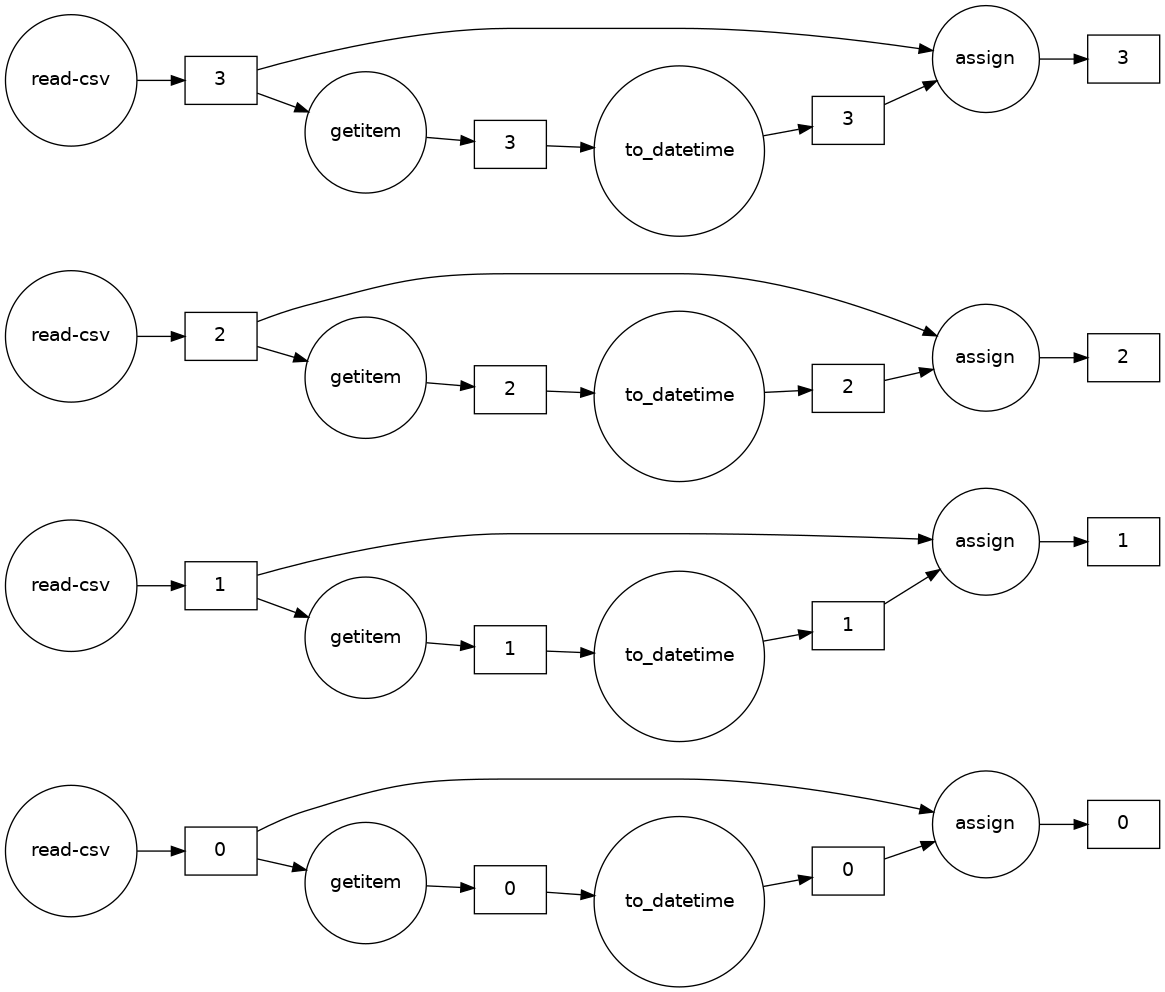

In [6]:
ddf.visualize(rankdir='LR')

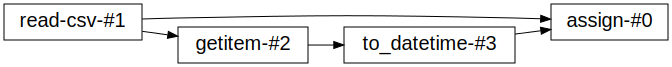

In [7]:
ddf.dask.visualize(rankdir='LR')

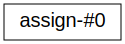

In [8]:
# persist data into distributed memory
ddf=ddf.persist()
wait(ddf)

# visualize task graph after persist
ddf.dask.visualize(rankdir='LR')

In [9]:
# preview DataFrame
ddf.head(npartitions=-1)

event_time event_type  product_id          category_id  \
0 2020-03-01 00:00:00       view    10900348  2232732105912091273   
1 2020-03-01 00:00:01       view    14300020  2232732107967300275   
2 2020-03-01 00:00:03       view    13200063  2232732061804790604   
3 2020-03-01 00:00:03       view   100077498  2232732085846540487   
4 2020-03-01 00:00:04       view     1005014  2232732093077520756   

                  category_code    brand       price    user_id  \
0      appliances.kitchen.mixer  kitfort  117.629997  550295099   
1             apparel.underwear    casio  264.369995  622070532   
2         furniture.bedroom.bed     <NA>  126.099998  552832344   
3  construction.tools.generator   tamina  424.720001  613391860   
4      construction.tools.light  samsung  482.730011  517021211   

                           user_session  
0  23f5ab9e-7774-416d-900b-f2725da671aa  
1  edf19213-f0dd-46e1-ae18-28968dbddd6e  
2  608087d8-6b69-21db-50a3-2b91ba015532  
3  5ab6c3d5-edd7-4e15-8b0a-75b467a37fd0  
4  0c34308d-c455-40bb-9992-3e44920bc2b9

<a name='s1-4'></a>
## Data Quality Check, Data Cleaning, and GroupBy Operations ##
An important and early step in the ETL process is to ensure that we have high quality data before it can be used for analytics. This will largely depend on upstream data providers, but it's prudent to perform some checks. We will perform two types of checks: 
1. Handling missing (also referred to as `NA`, `nan`, or null) values
2. Filter to relevant data

Below are some facts we know about this dataset: 
* Each `user_session` can only be associated with one unique `user_id`
* `price` can vary across time for the same `product_id`, even within the same `user_session`
* `category_id`, `category_code`, and `brand` values are mostly unique for each `product_id`
* Some `purchase (event_type)` occurs without `purchase (cart)` first
* Rows with the same `user_session` can be associated with multiple `product_id`

<a name='s1-4.1'></a>
### Handling Missing Values ###
Missing data can arise for many reasons and most datasets contain them. We can use `.isna()` or `.isnull()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.dataframe.isnull), followed by `.sum()` to detect and count the number of missing values. This works logically since `.isna()` returns `True` when values are missing and `False` otherwise. We then call `.sum()` on the boolean values, which uses `1` for `True` values and `0` for `False` values. Note that we need to call `.compute()` to examine the output cuDF DataFrame. 

Null values propagate naturally through arithmetic operations between cuDF objects but can behave differently on calculations. In some cases, it may not be necessary to treat them. For example, while summing data along a `cudf.Series`, `NA` values will be treated as `0`. The `sum` and `mean` methods support `skipna` parameters, which defaults to `True`. Cumulative methods like `.cumsum()` and `.cumprod()` ignore `NA` values by default, same with `GroupBy` operations. Since `NA` values are treated as `0`. `NA` values are automatically excluded in `GroupBy` operations. 

There are several ways to handle null values: 
* Fill with static value using `.fillna()`
* Infer from other data points
* Drop from dataset

In [10]:
# check number of null values per column
ddf.isna().sum().compute()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    5938692
brand            8123632
price                  0
user_id                0
user_session          51
dtype: int64

There are missing values for `category_code` and `brand`. To deal with missing values, we can use `.fillna()` to fill missing values with a static value or based on some inference. As a last resort, we can drop records with missing values with `.dropna()`. 

We will further investigate these columns to see if any of the missing values can be inferred. Specifically, knowing that each `product_id` should be associated with one `category_code`, we want to see if `category_code` is missing for all records with the same `product_id`. If any `category_code` value exists for records that share the same `product_id` value, we will be able to fill the missing values for all records with that `product_id`. There are several ways to approach this. We break down the procedure into the following steps: 
1. Get a list of `product_id` values from records that have null `category_code` values
2. Get all records associated with the previous list of `product_id` values
3. Count the number of `category_code` values for each group of records that share the same `product_id` value - a `0` is expected if `category_code` is missing for all members of a group

**Step 1**. Get a list of `product_id` values from records that have null `category_code` values

We can use `dask_cudf.core.DataFrame.loc` to get a subset of the DataFrame. The `.loc` property selects rows and columns by label or [boolean mask](https://docs.rapids.ai/api/cudf/stable/user_guide/10min/#boolean-indexing). It uses the syntax `.loc[row(s), column(s)]`, `.loc[boolean_mask]`, `.loc[boolean_mask, column(s)]`, or `.loc[row]`. For the boolean mask, we use `dask_cudf.core.Series.isnull()` so we get all the rows that have missing `category_code` values. We have to call `.compute()` here since we need the resulting list. 

In [11]:
# get list of product_id values with null category_code values
null_category_products=ddf.loc[ddf['category_code'].isnull(), 'product_id'].unique()
null_category_products_list=null_category_products.compute()
null_category_products_list

0          1480001
1          1480009
2          2600018
3          2600110
4          2600128
           ...    
44534    100184194
44535    100184216
44536    100184465
44537    100184512
44538    100184513
Name: product_id, Length: 44539, dtype: int32

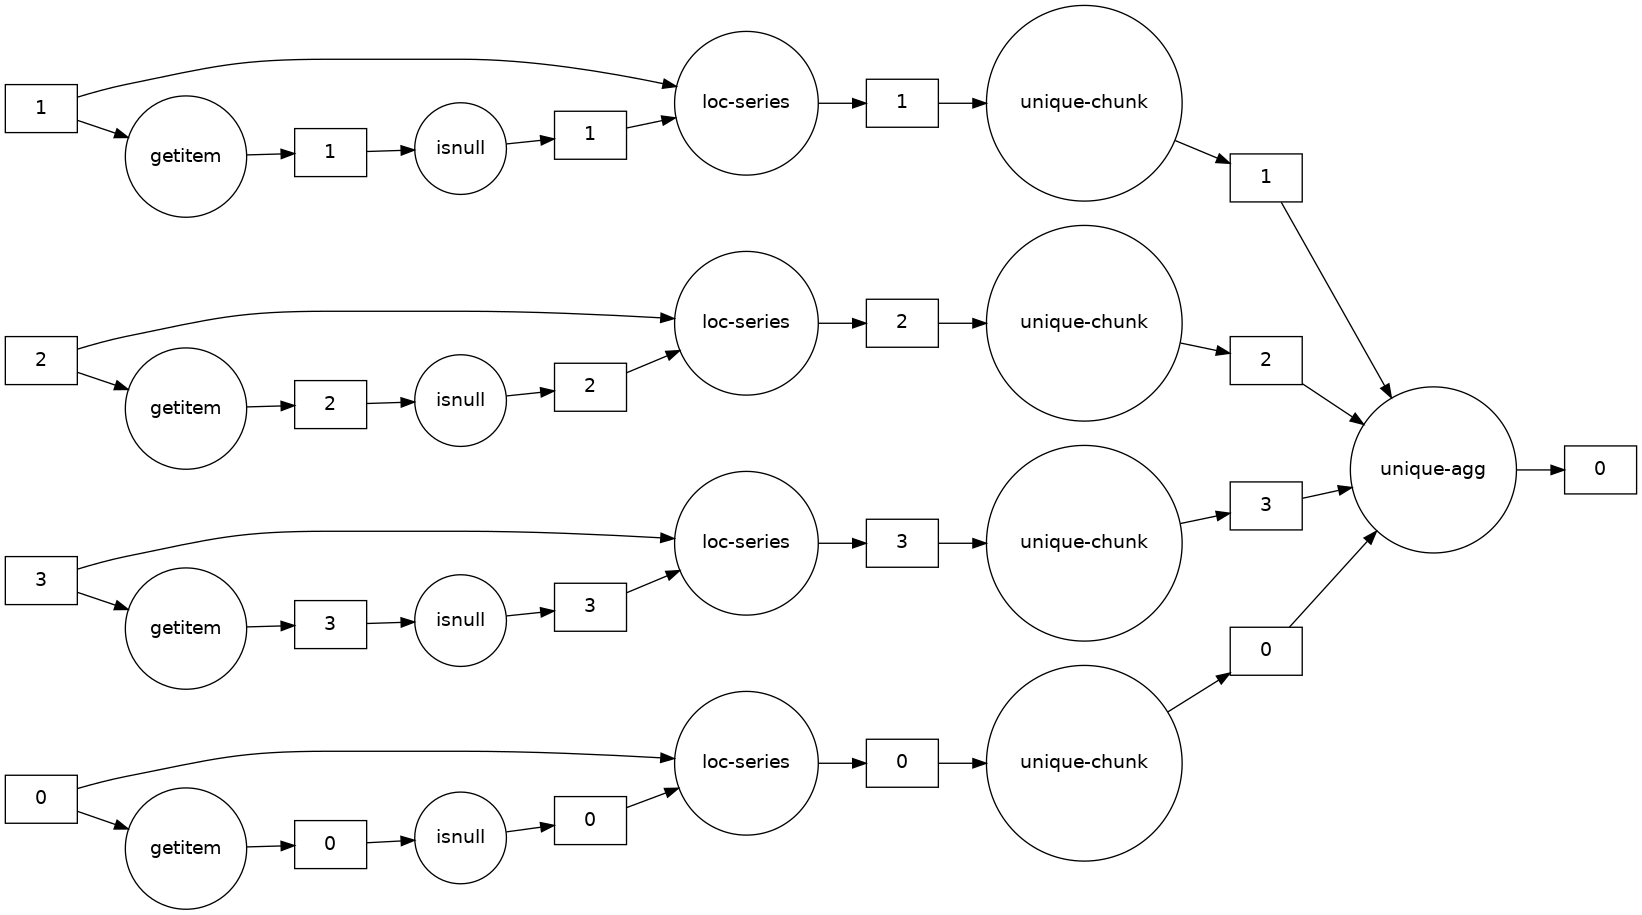

In [12]:
# visualize graph
null_category_products.visualize(rankdir='LR')

**Step 2**. Get all records associated with the previous list of `product_id` values

There are quite a bit of products that do not have an associated `category_code` value. We will use `dask_cudf.core.DataFrame.loc` again to get a subset of the DataFrame. For the boolean mask, we use `dask_cudf.core.Series.isin()` so we get all the rows with a `product_id` value that is within the previous `product_id` values list. We have to call `.compute()` here to see the result. 

In [13]:
# get records associated with missing category_code
null_category_products_ddf=ddf.loc[ddf['product_id'].isin(null_category_products_list), ['product_id', 'category_code']]

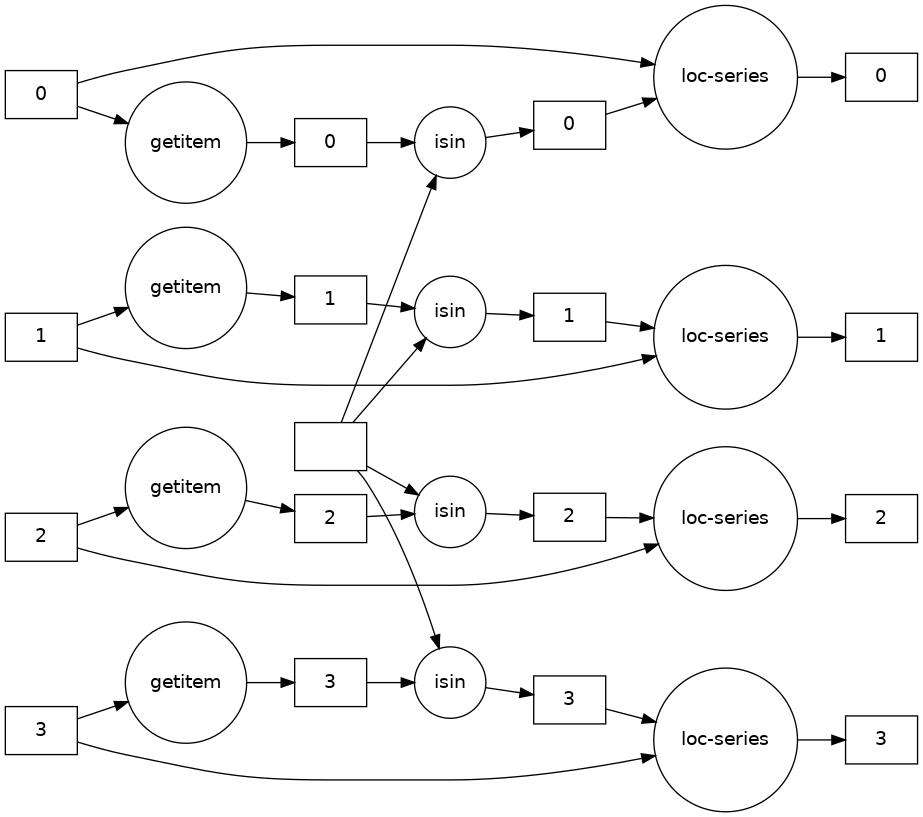

In [14]:
# visualize graph
display(null_category_products_ddf.visualize(rankdir='LR'))

**Step 3**. Count the number of `category_code` values for each group of records that share the same `product_id` value - a 0 is expected if category_code is missing for all members of a group

Groupby operations are common for ETL and analysis in which we split data into groups, apply a function to each group independently, and then combine the results back together. 

<p><img src='images/groupby.png' width=720></p>

The typical syntax for a groupby operation is `ddf.groupby('col')`, followed by `.aggregate()`, `.transform()`, or `.apply()`. `.groupby()` can cause memory to spike when computing. This is related to the intermediate `DataFrameGroupBy`s that are created. This is obvious when there are a lot of groups in the data. Even if the groups have very few records, there will be a lot of overhead. Being aware of this behavior and being aware of the "groupiness" of the data can help avoid memory spilling. 

_Shuffle_ is a frequent challenge that arise in distributed computing. It involves _broadcasting_ all partitions to all workers. Shuffling is necessary when performing _sorting_, _grouping_, and _indexing_ operations, because each row needs to be compared with every other row in the entire Dask DataFrame to determine its correct relative position. This is a time-expensive operation, because it necessitates transferring large amounts of data. Therefore, groupby operations require special consideration and failure to consider how they work may result in significant slowdowns. At a high-level, we want to avoid communication and transfer of data across partitions. Furthermore, the performance of Dask's groupby operations will largely depend on the number of groups and how they are organized in the partitions. 

Generally, there are three types of groupby operations: 
* `.aggregate(func)` or `agg(func)` - aggregate using one of the built-in operations or a custom one. Several built-in aggregation methods are supported such as `sum`, `count`, `mean`, `var`, `std`, `max`, `min`, etc. The full list can be found [here](https://docs.rapids.ai/api/cudf/stable/user_guide/groupby/#aggregation)
    
    Dask uses an ACA (apply-concat-apply) procedure for groupby aggregations. This is usually an efficient operation and generally quite fast because it can be broken down into well known operations. The data doesn't have to move around too much and we can pass around small intermediate values across workers. Each stage is effectively a reduction and data from each group is eventually collapsed into a single row based on `func`. By default, groupby aggregations return the result as a single partition DataFrame. Since the results are usually quite small, this is usually a good choice. However, this becomes an issue when there are many groups and the result doesn't fit in memory. We can use the `split_out` parameter to split the output into multiple partitions. In the below example, we illustrate `ddf.groupby('group')['value'].sum()`. By default, `split_out` is set to 1 (left). We can compare this with `split_out` being set to 2 (right). If computed, Dask will: 
    1) perform sum aggregation on each partition
    2) concatenate the results in into `split_out` partitions
    3) performs a sum aggregation on the concatenated results.     
    
    <p><img src='images/groupby_aggregation_comp.png' width=1080></p>
    
* `.transform(func)` - apply `func` group-wise without changing its shape and return a DataFrame filled with the transformed values. Good examples of this are `.cumsum()` and `.diff()`. In addition to custom functions, `.transform()` also supports many of the built-in aggregation methods such as `sum`, `count`, `mean`, `var`, `std`, `max`, `min`, etc. If `func` returns a scalar value, it will be broadcasted across the group to have the same index as the input subframe (group). The returned object will have the same index and shape as the original

* `.apply(func)` - apply `func` group-wise and combine the results after. The returned object can have any arbitrary size and shape

    Some groupby operations require all data from a given group. This is an _expensive_ operation that requires shuffling and will force a great deal of communication amongst partitions. This should be avoided if a groupby aggregation works. The `meta` parameter is a prescription of the names and data types of the output from the computation. This is required because `.apply()` is flexible enough that it can produce just about anything from a Dataframe. If we don't provide a `meta`, then Dask actually computes part of the data to see what the types should be. We can avoid this pre-computation, which can be expensive, and be more explicit when we know what the output should look like. This parameter is available on all functions/methods that take user provided callables such as `DataFrame.map_partitions()` and `DataFrame.apply()`. The `meta` parameter can be a zero-row version of the output (dataframe or series), or just the types. 
    
    <p><img src='images/groupby_apply.png' width=720></p>
    
Now that we have a subset of the original DataFrame that only contains records with `product_id`s that are partially or fully missing `category_code` values, we want to see if we can infer the missing values. We will try this using various approaches and discuss the differences: 
1. `df.count()` - we will rely on null values returning 0 for `.count()`. Without performing a `.groupby()`, we do not know which specific `product_id` can be inferred. 
2. `df.groupby().agg('count')` or `df.groupby().count()` - we will rely on null values returning 0 for `.count()`. 
3. `df.groupby().agg('count', split_out)` or `df.groupby().count(split_out)` - we will see the result of `split_out`. 
4. `df.notnull().groupby().agg('sum')` or `df.notnull().groupby().sum()`- we will rely on using `0` for `False` values. 
5. `df.groupby().transform('count')` - we will rely on null values returning 0 for `.count()`. 
6. `df.groupby().transform(lambda x: x.count())` - we will rely on null values returning 0 for `.count()`. 
7. `df.groupby().apply(lambda x: x.count())` - we will rely on null values returning 0 for `.count()`. 
8. `df.groupby().apply(lambda x: x.isnull().all())` - we will rely on null values returning `True` for `.isnull().all()`. 

<p><img src='images/tip.png' width=720></p>

`cudf.DataFrame.groupby` does not sort by default for better performance. 

In [15]:
# since we want to compare multiple approaches, we persist the data into distributed memory, where new tasks will start from
null_category_products_ddf=null_category_products_ddf.persist()
wait(null_category_products_ddf)

# create a dictionary to compare options
groupby_options={}

In [16]:
# OPTION 1
time=timeit(
    lambda: null_category_products_ddf['category_code'].count().compute(), 
    number=1
)
groupby_options['count()']=time
print(f'Took {time} seconds')

print(f"There are {null_category_products_ddf['category_code'].count().compute()} products with at least one category_code populated. ")

Took 0.03267434899953514 seconds
There are 0 products with at least one category_code populated. 


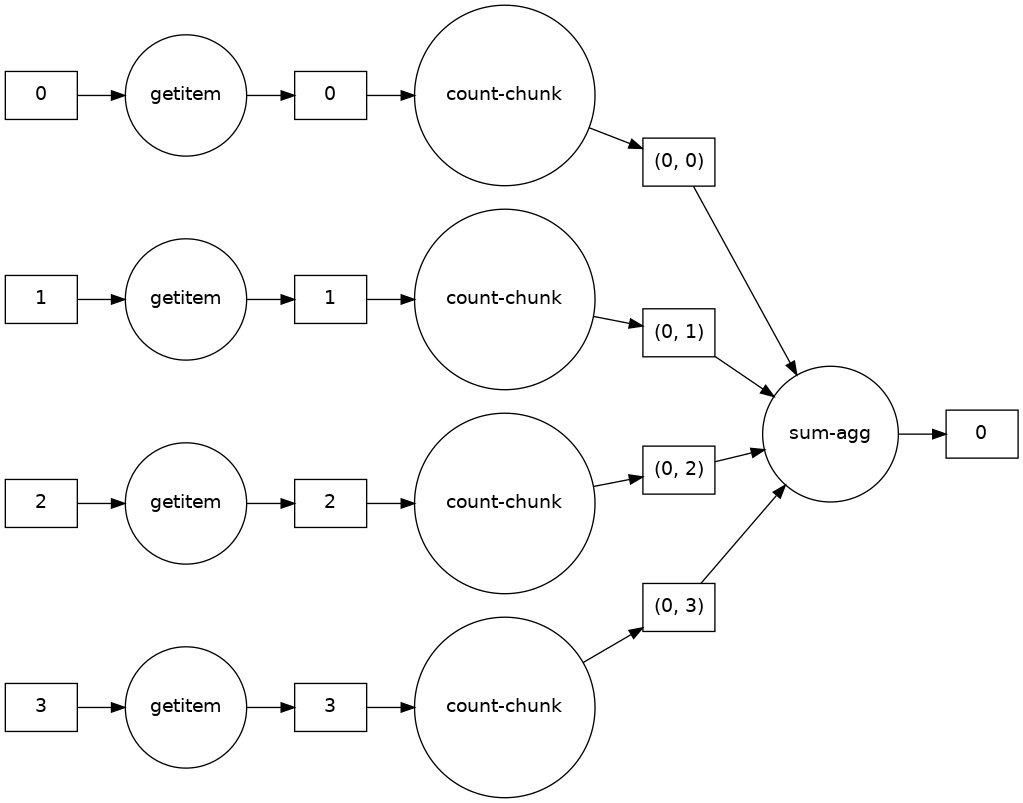

In [17]:
# visualize graph
null_category_products_ddf['category_code'].count().visualize(rankdir='LR')

Based on the count being 0, we know that `category_code` isn't populated for any of these records. 

In [18]:
# OPTION 2
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].agg('count')

# alternative way to achieve similar results
# null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].count()

time=timeit(
    lambda: (null_category_products_count_ddf>0).sum().compute(), 
    number=1
)
groupby_options['groupby().agg("count")']=time
print(f'Took {time} seconds')

Took 0.06285881299936591 seconds


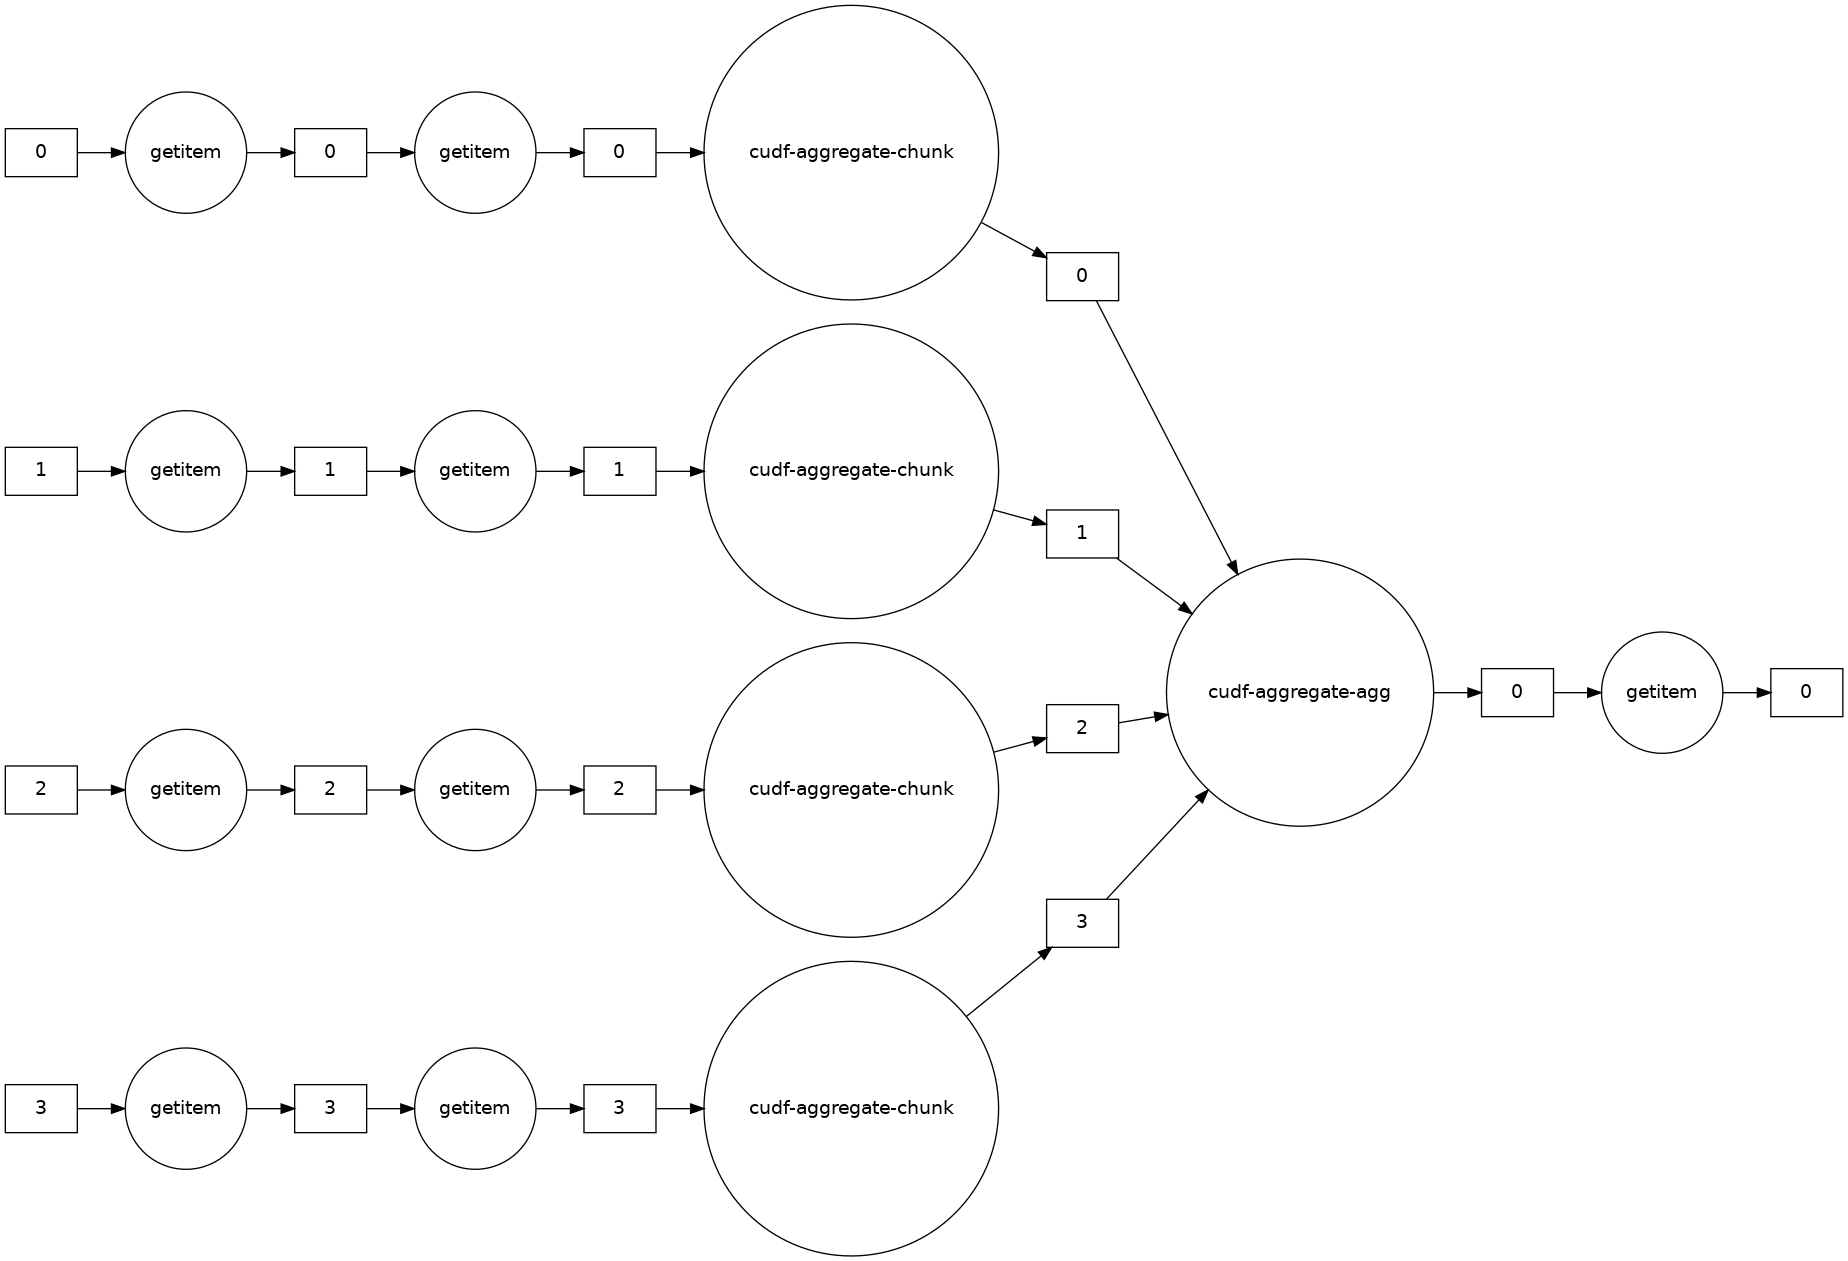

In [19]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

In [20]:
# OPTION 3
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].agg('count', split_out=2)

# alternative way to achieve similar results
# null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].count(split_out=2)

time=timeit(
    lambda: (null_category_products_count_ddf>0).sum().compute(), 
    number=1
)
groupby_options['groupby().agg("count", split_out=2)']=time
print(f'Took {time} seconds')

Took 0.06949391500074853 seconds


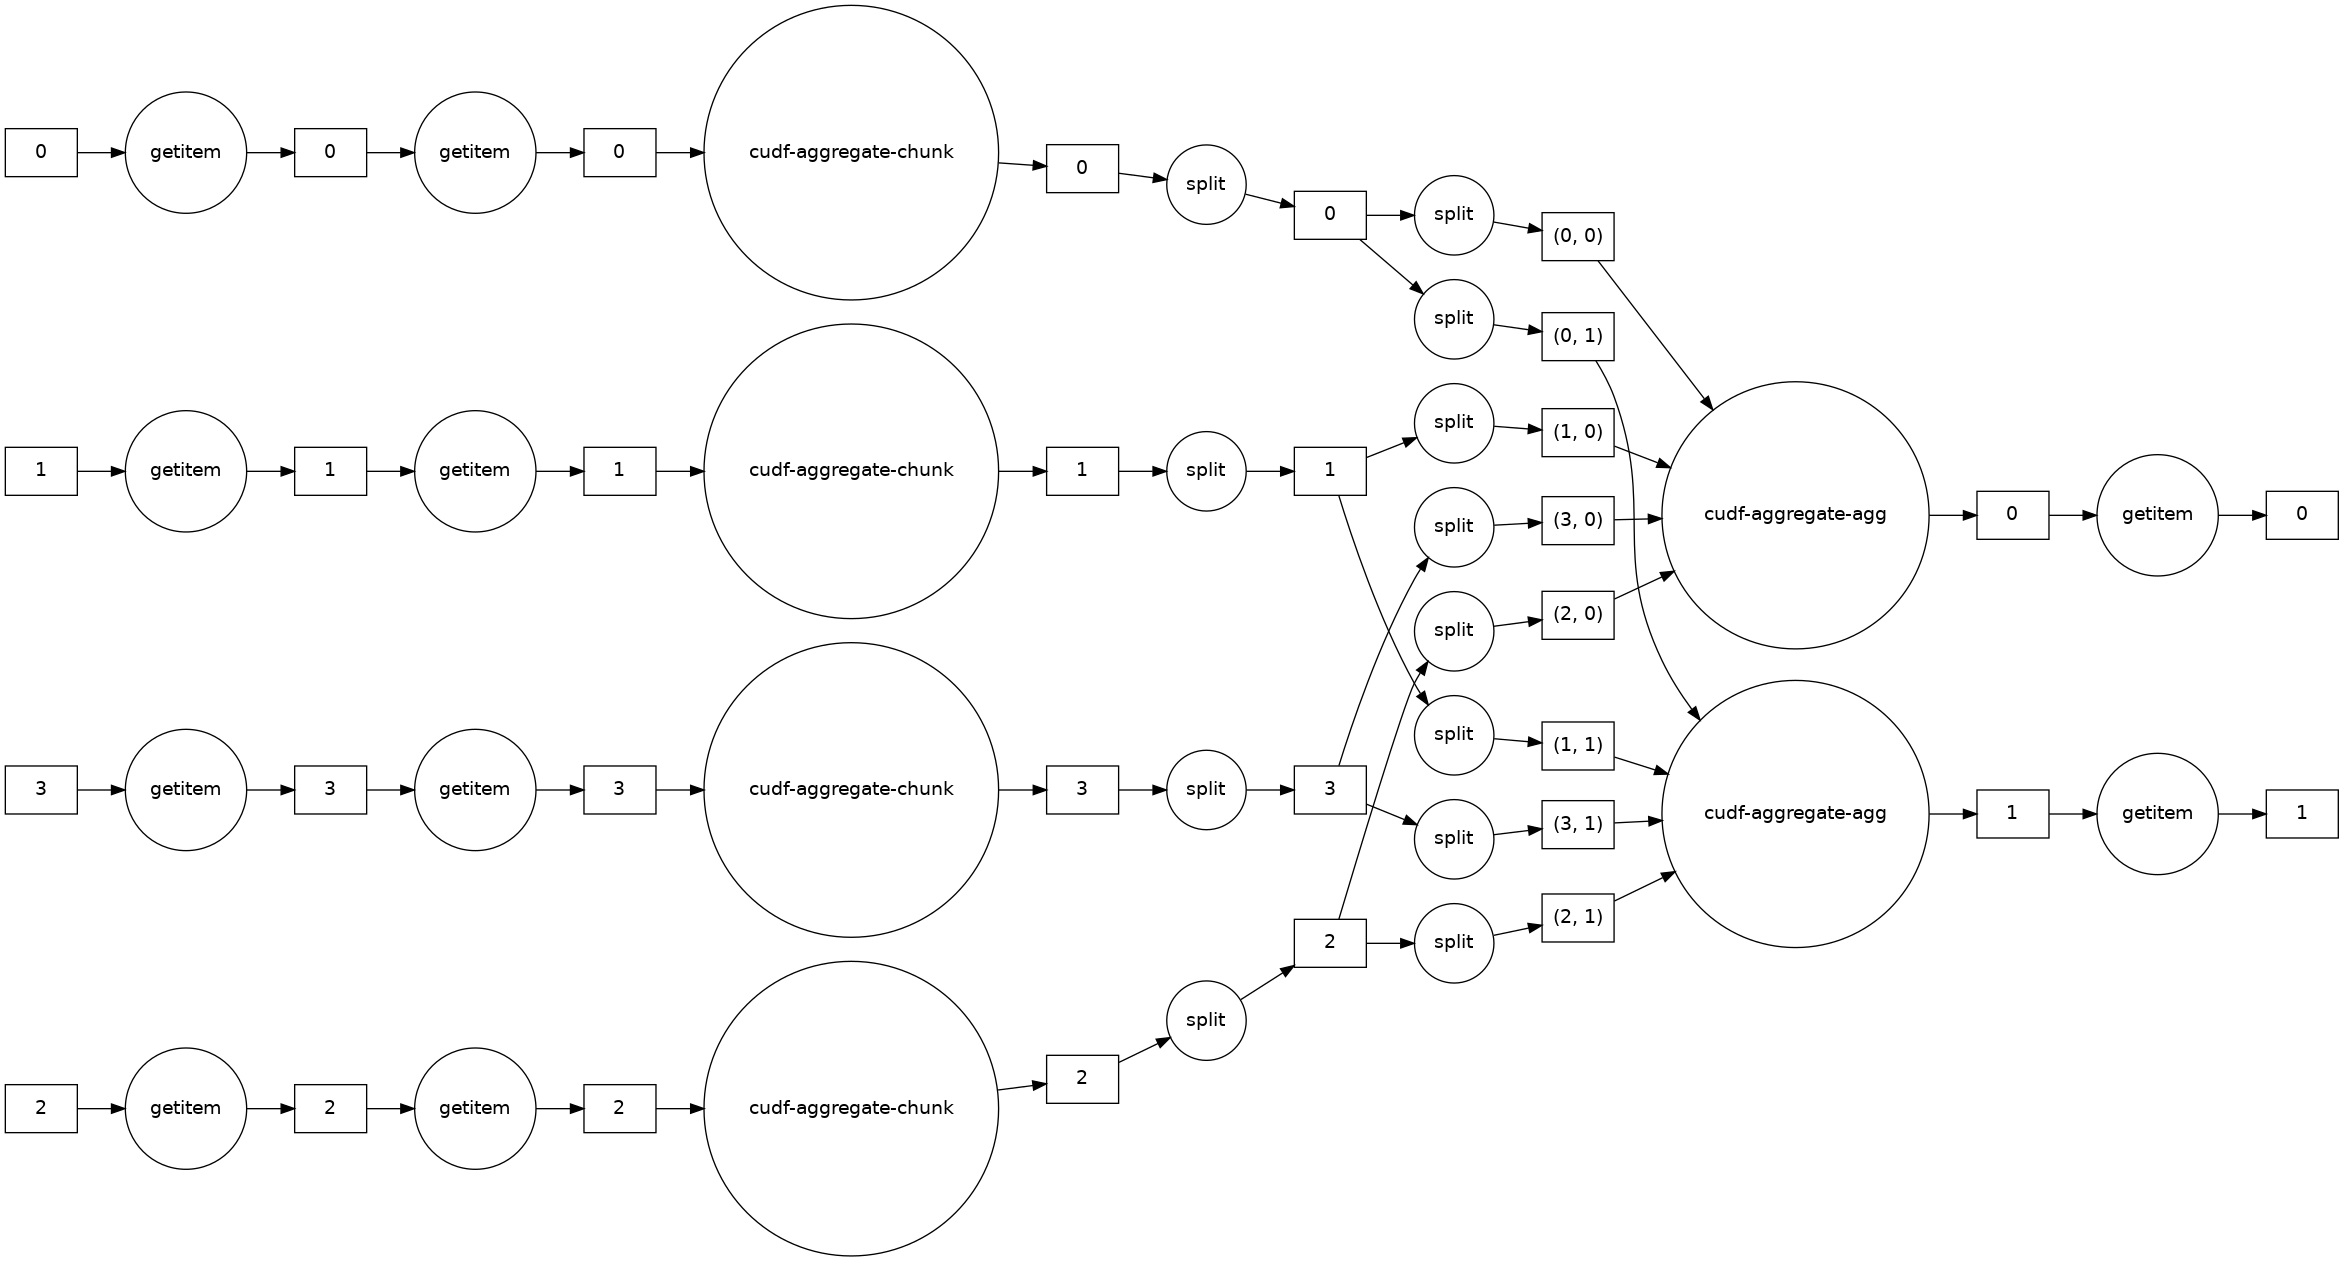

In [21]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

In [22]:
# OPTION 4
null_category_products_count_ddf=null_category_products_ddf.notnull().groupby(null_category_products_ddf['product_id'])['category_code'].agg('sum')

time=timeit(
    lambda: null_category_products_count_ddf.sum().compute(), 
    number=1
)
groupby_options['notnull().groupby().agg("sum")']=time
print(f'Took {time} seconds')

Took 0.05322945999978401 seconds


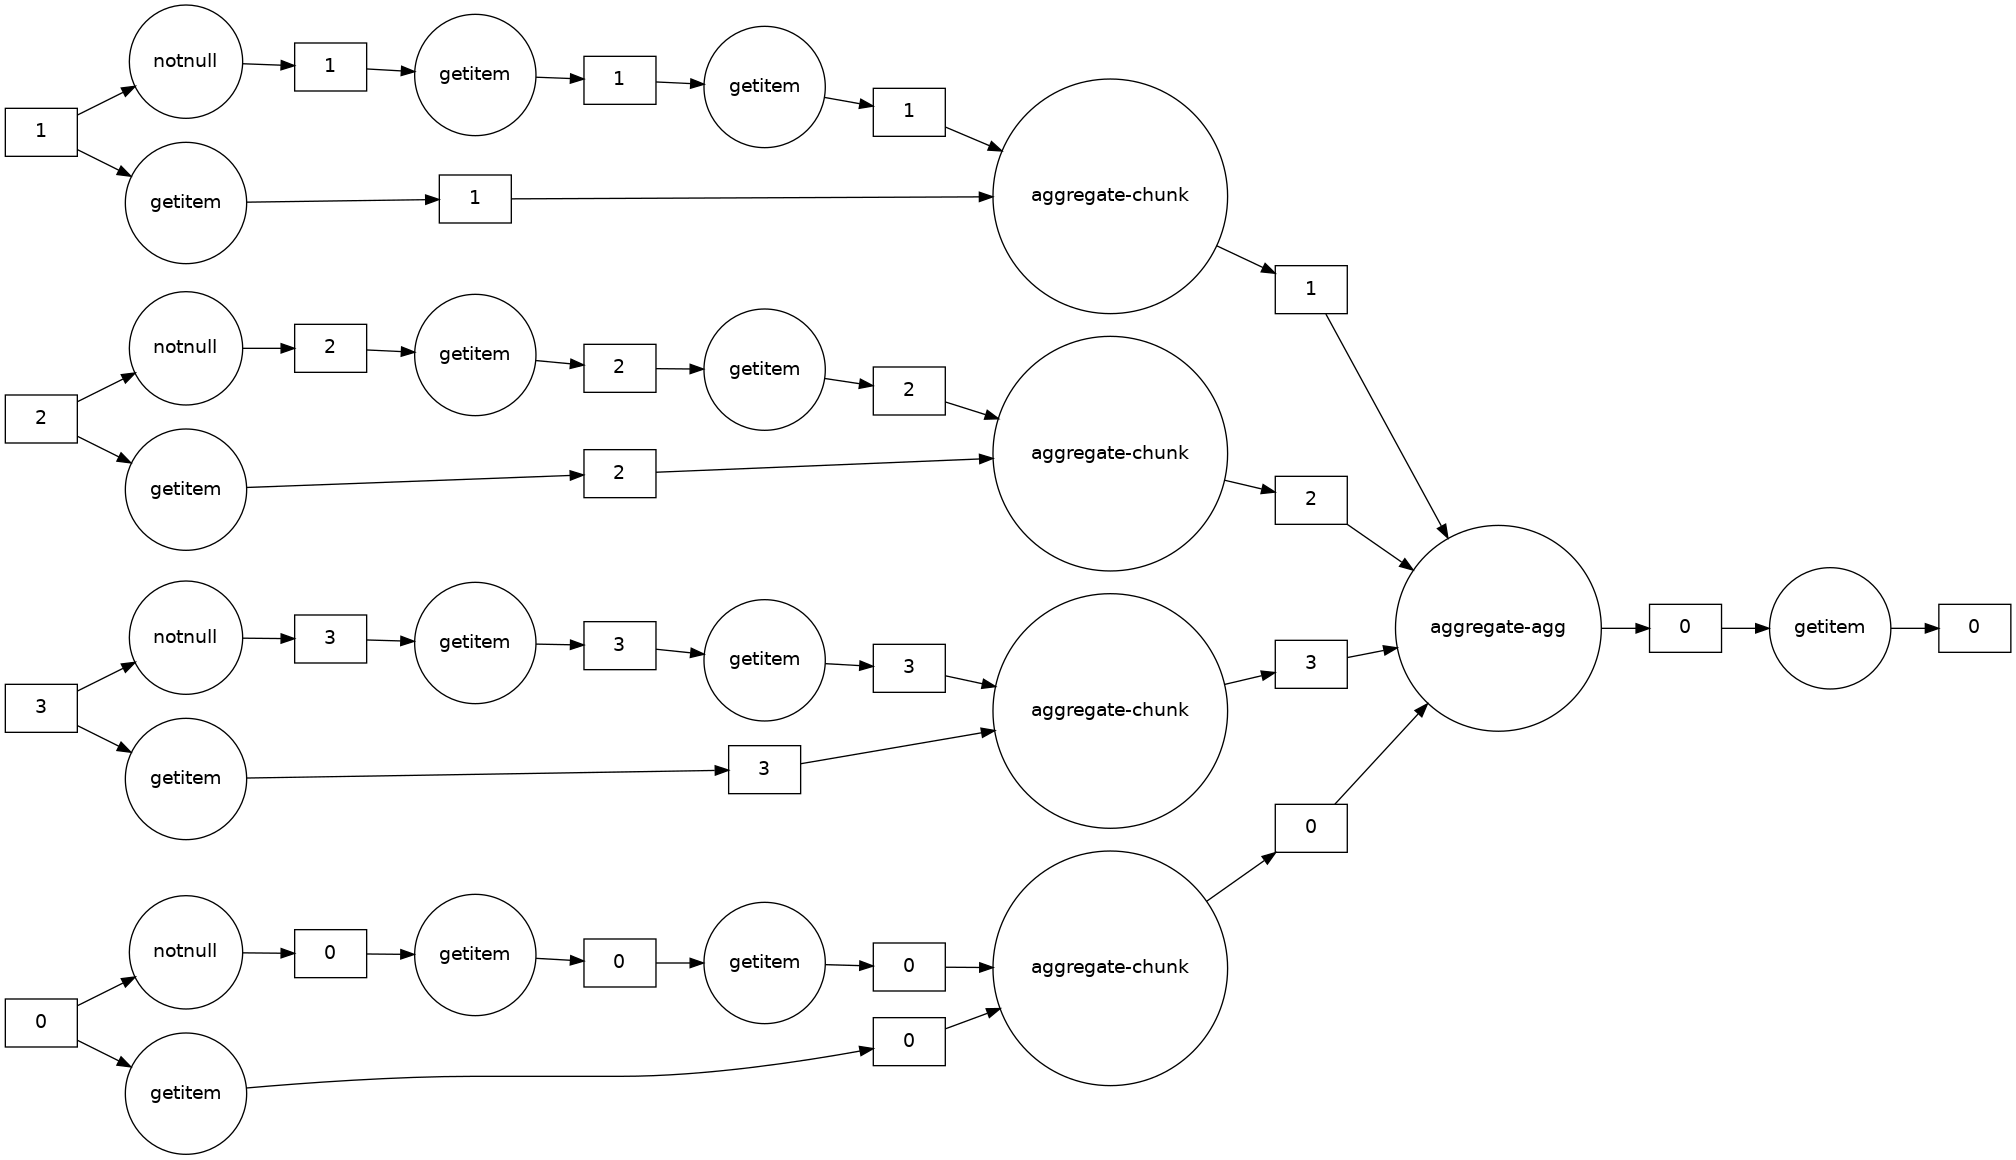

In [23]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

In [24]:
# OPTION 5
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].transform('count', meta=('category_code_count', 'int32'))

time=timeit(
    lambda: null_category_products_count_ddf.sum().compute(), 
    number=1
)
groupby_options['groupby().transform("count")']=time
print(f'Took {time} seconds')

Took 0.6917947350002578 seconds


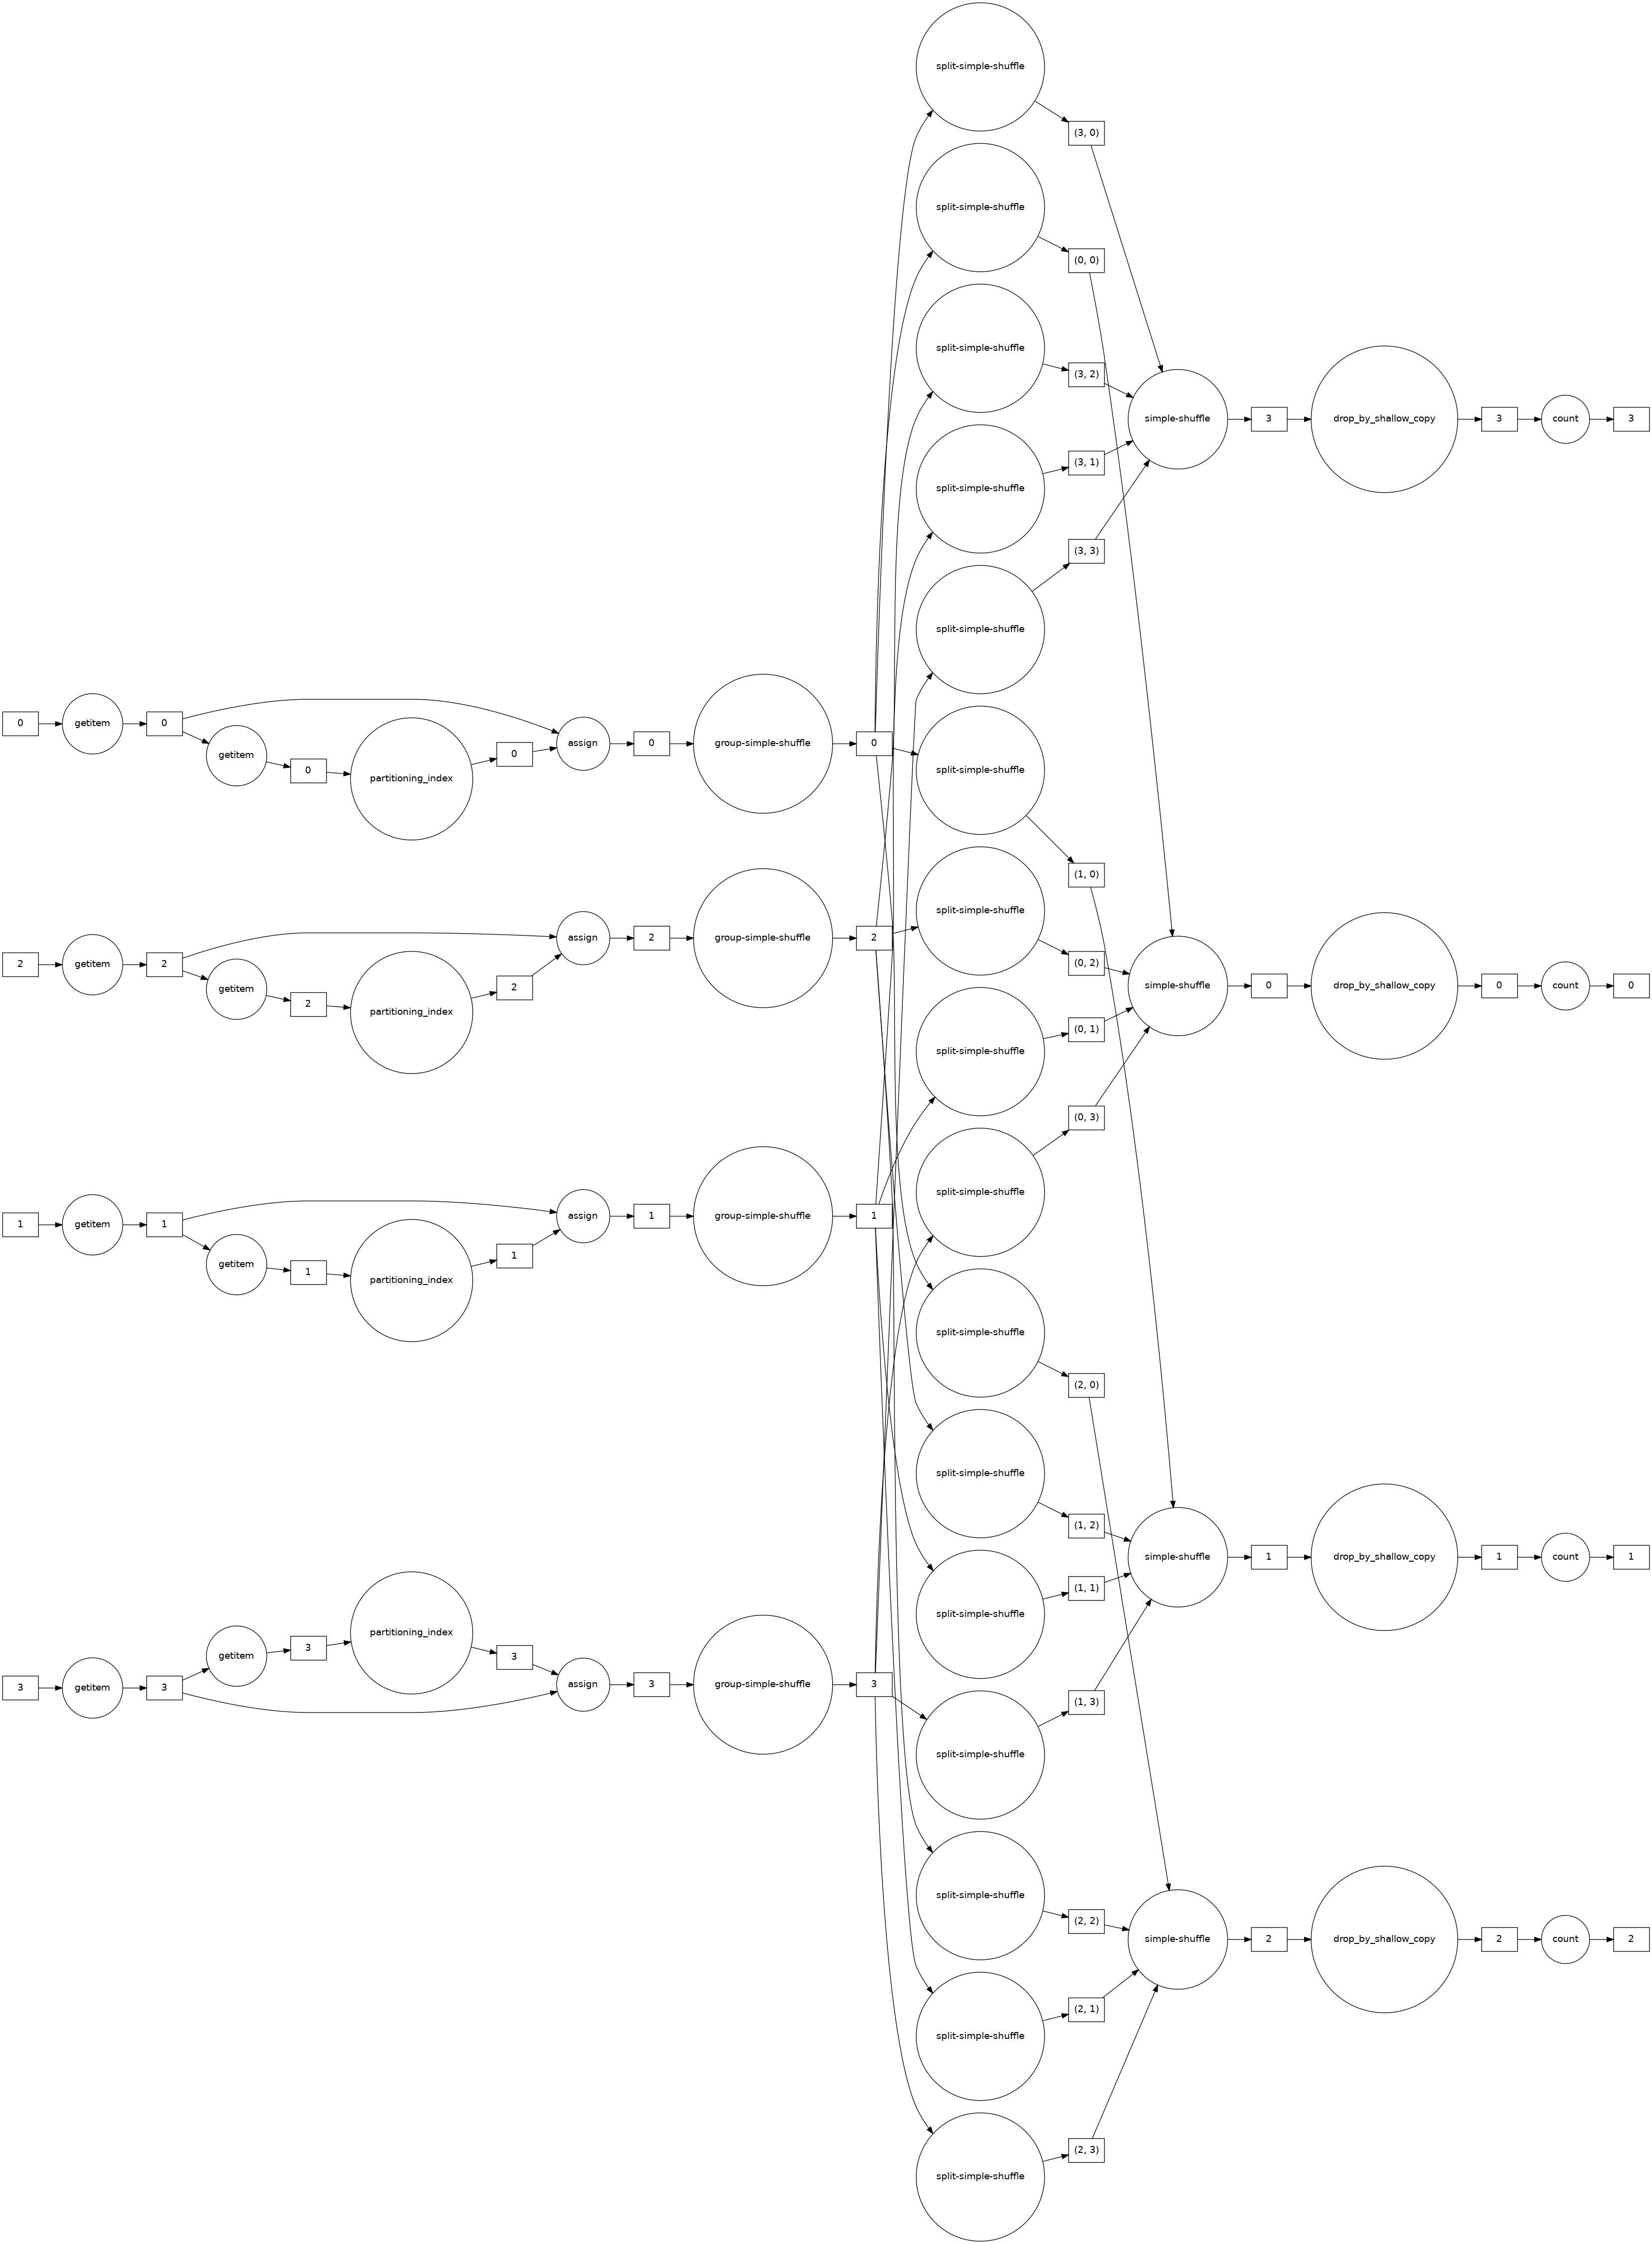

In [25]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

In [26]:
# OPTION 6
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].transform(lambda x: x.count(), meta=('category_code_count', 'int32'))

time=timeit(
    lambda: null_category_products_count_ddf.sum().compute(), 
    number=1
)
groupby_options['groupby().transform(lambda x: x.count())']=time
print(f'Took {time} seconds')

Took 0.7787153489998673 seconds


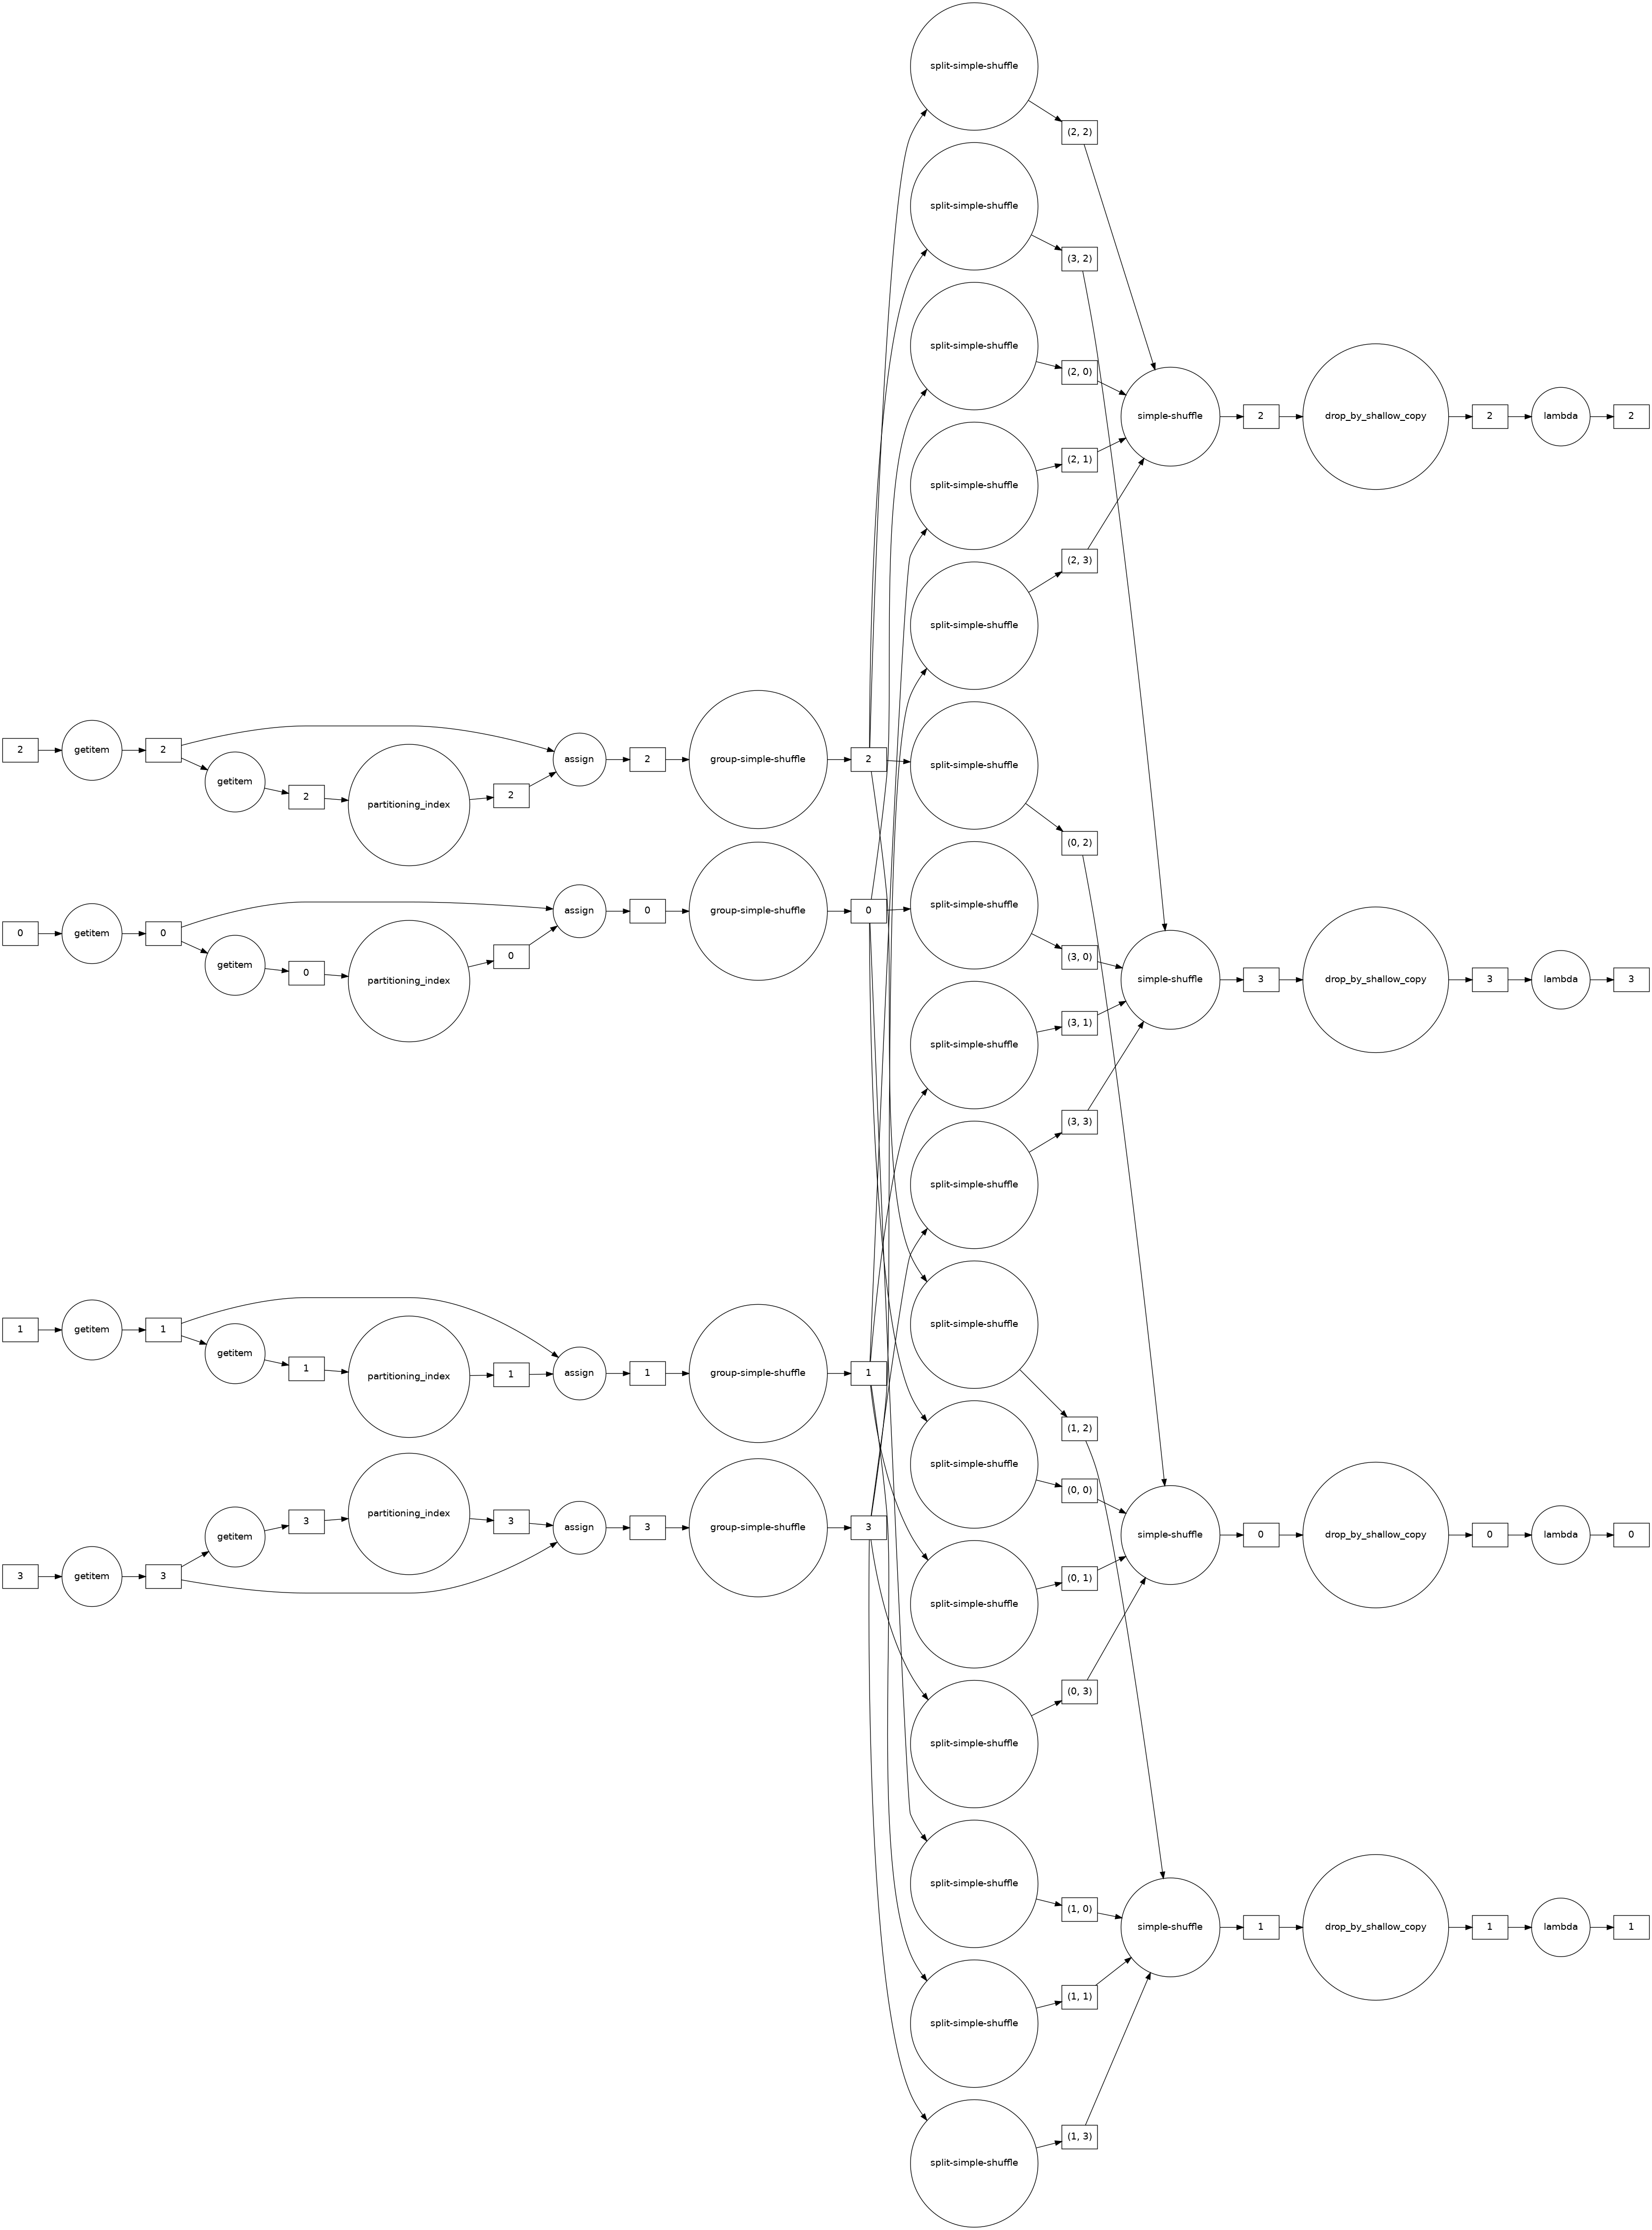

In [27]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

In [28]:
# OPTION 7
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].apply(lambda x: x.count(), meta=('category_code_count', 'int32'))

time=timeit(
    lambda: null_category_products_count_ddf.sum().compute(), 
    number=1
)
groupby_options['groupby().apply(lambda x: x.count())']=time
print(f'Took {time} seconds')

/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11244 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11046 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11176 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11073 groups.
  warnings.warn(


Took 5.547940957999344 seconds


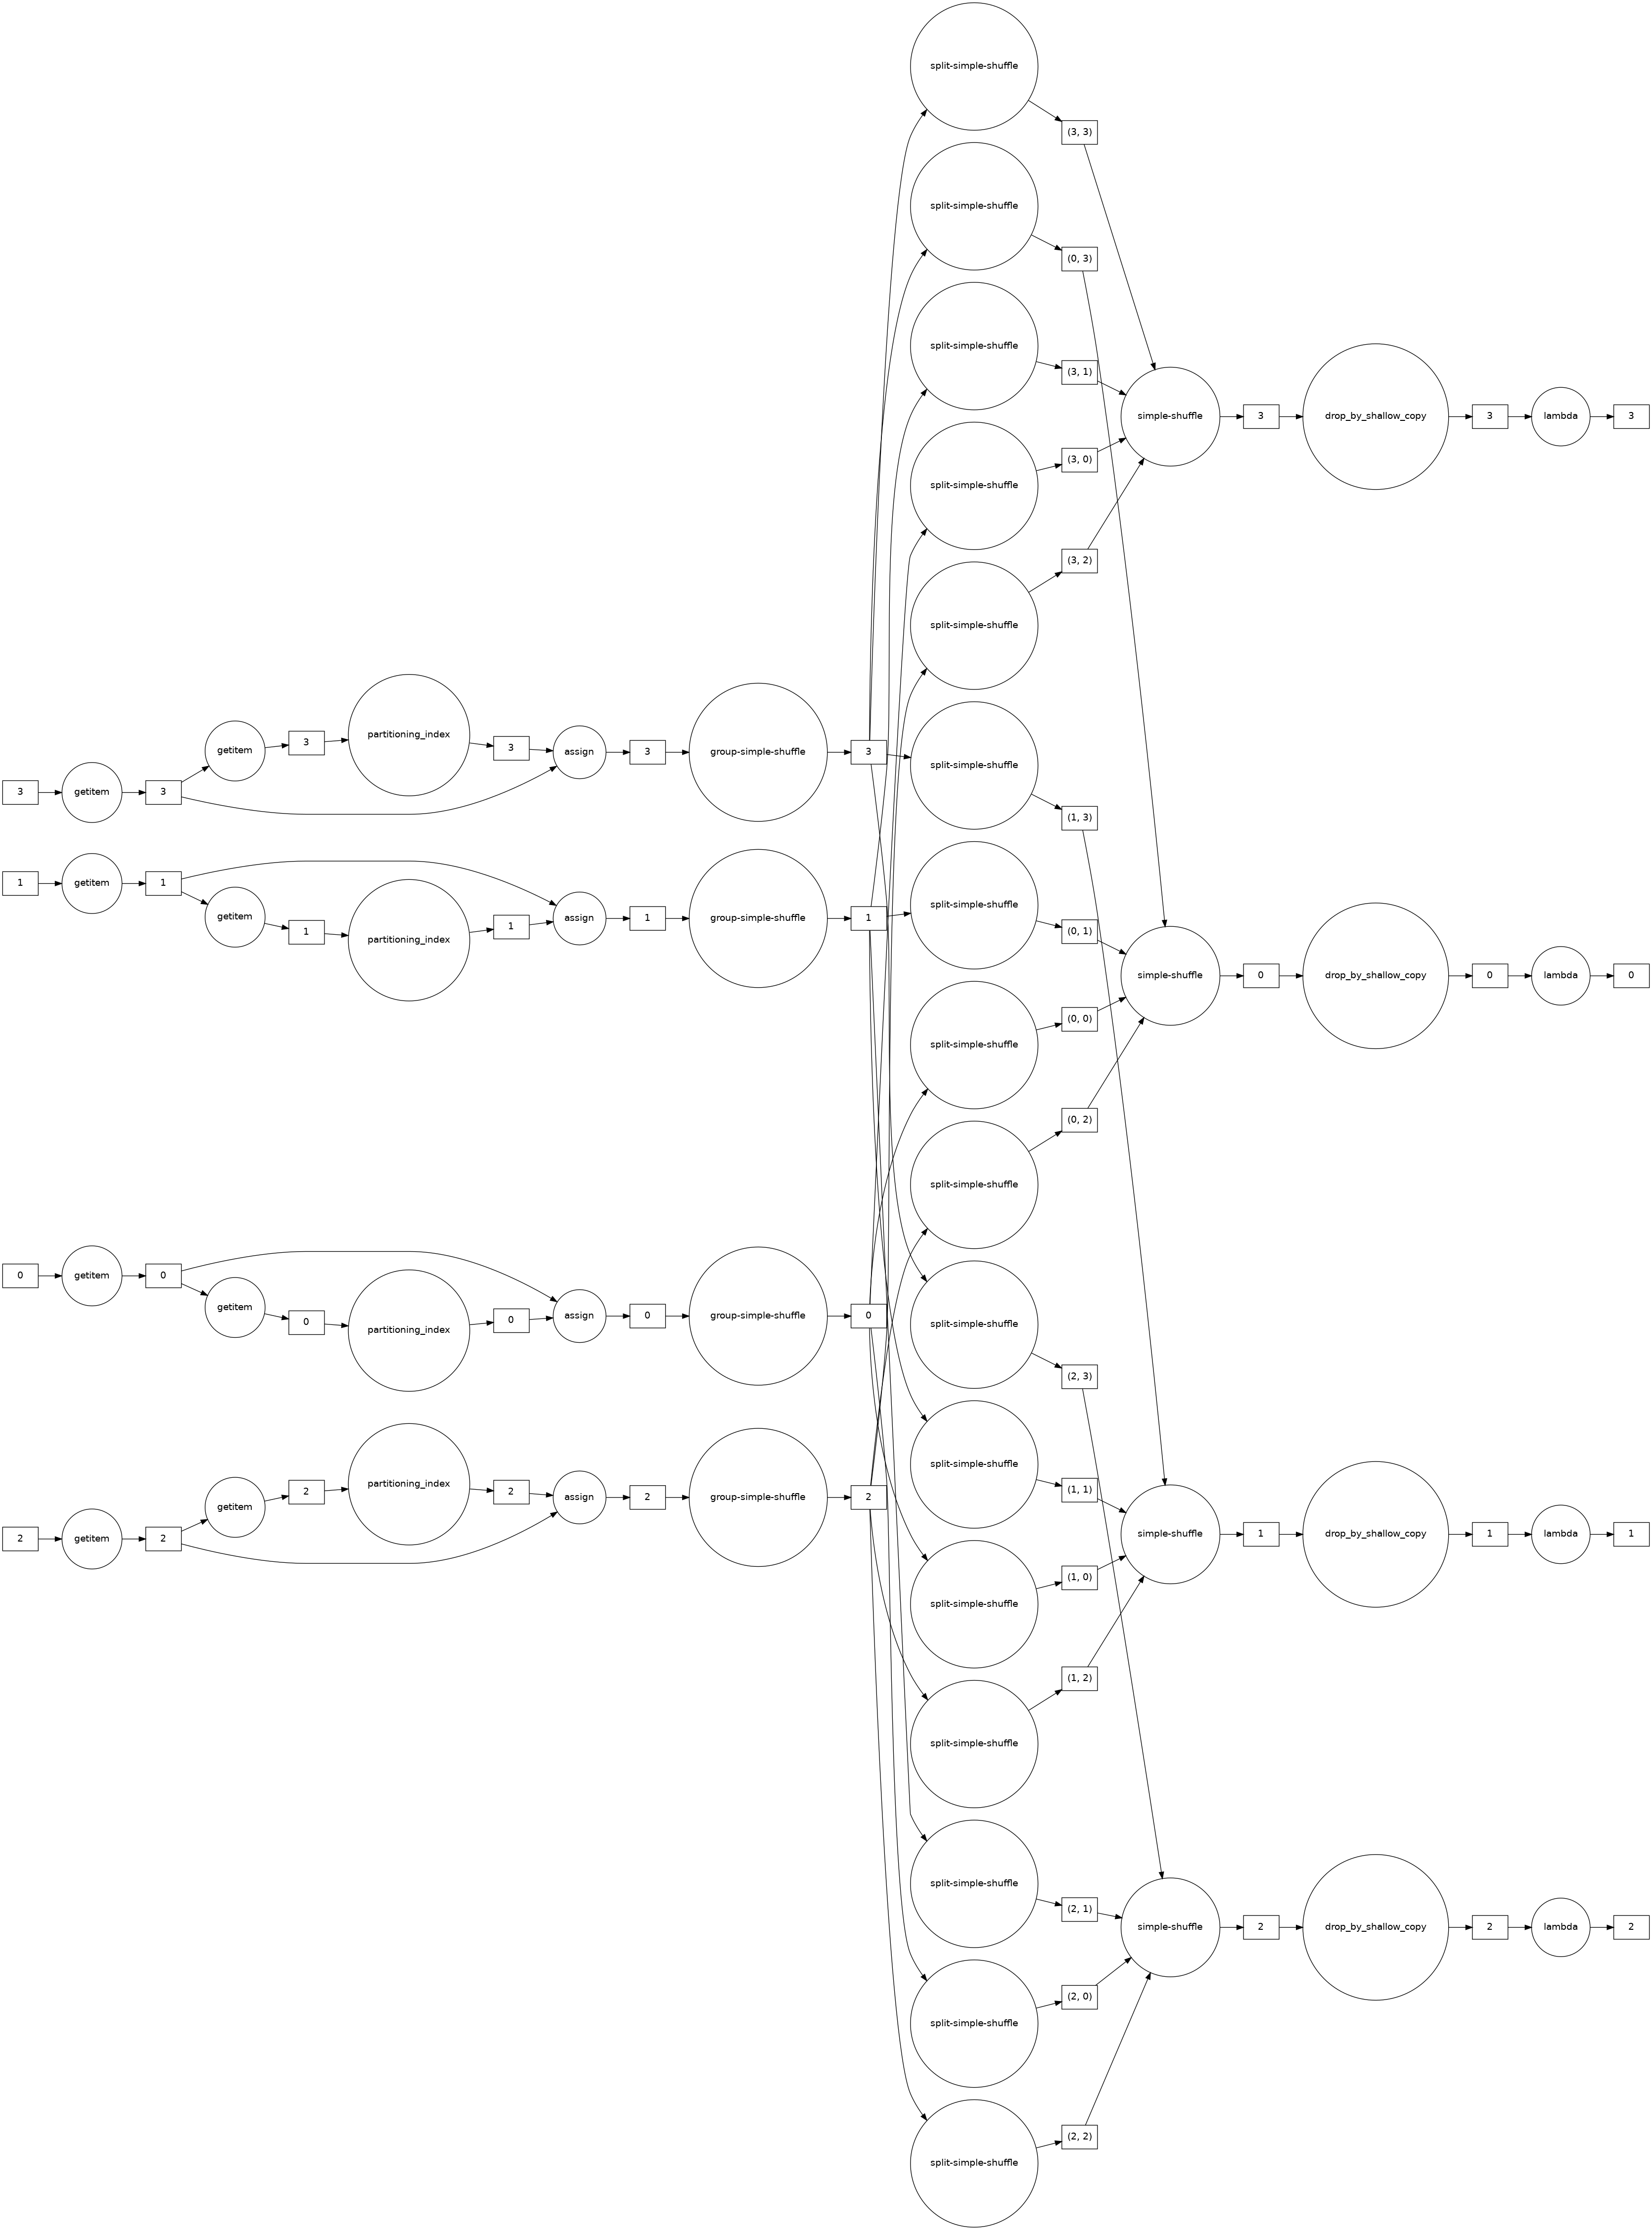

In [29]:
# visualize graph
display(null_category_products_count_ddf.visualize(rankdir='LR'))

In [30]:
# OPTION 8
null_category_products_count_ddf=null_category_products_ddf.groupby('product_id')['category_code'].apply(lambda x: x.isnull().all(), meta=('category_code_null', 'boolean'))

time=timeit(
    lambda: (~null_category_products_count_ddf).sum().compute(), 
    number=1
)
groupby_options['groupby().apply(lambda x: x.isnull().all())']=time
print(f'Took {time} seconds')

/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11244 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11073 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11046 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 11176 groups.
  warnings.warn(


Took 8.66931819399997 seconds


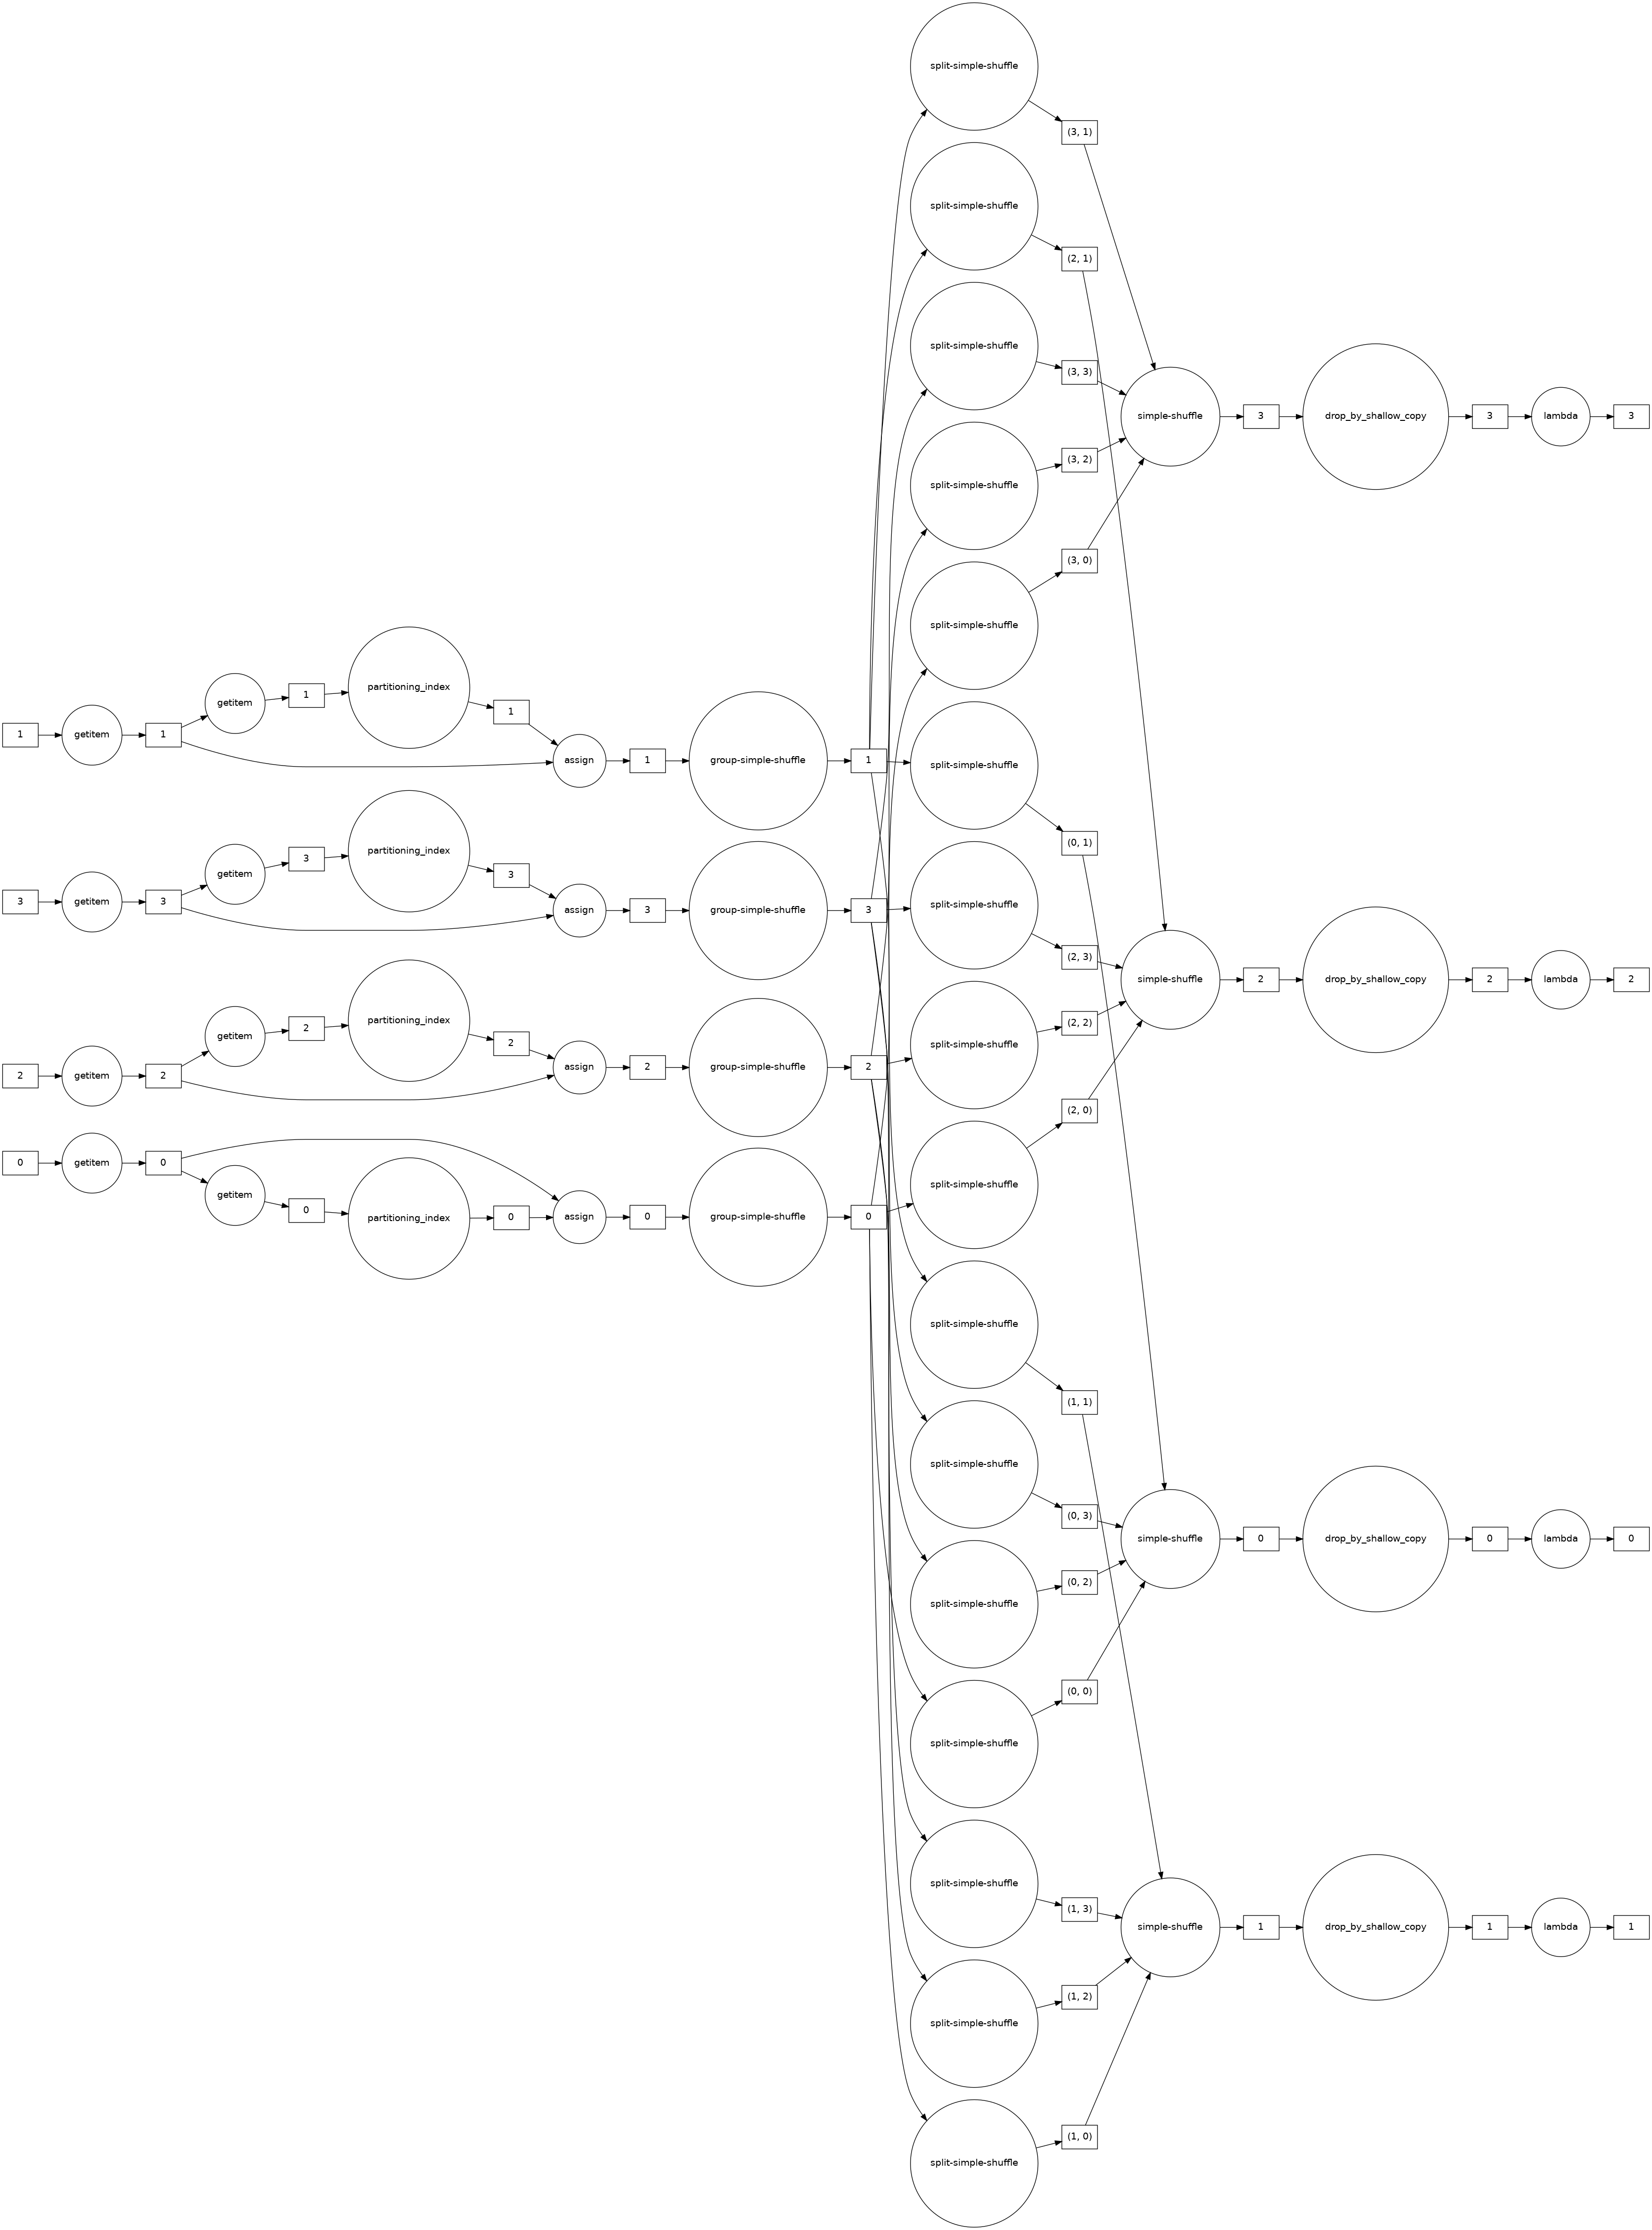

In [31]:
# visualize graph
null_category_products_count_ddf.visualize(rankdir='LR')

<a name='s1-e3'></a>
### Exercise #3 - Understanding GroupBy Operations Behavior ###

**Instructions**: <br>
* Execute the below cell to plot the performance comparison across various groupby operations. 
* Describe why there is discrepancy between the options in the cell below. 

Text(0, 0.5, 'Compute Time (s)')

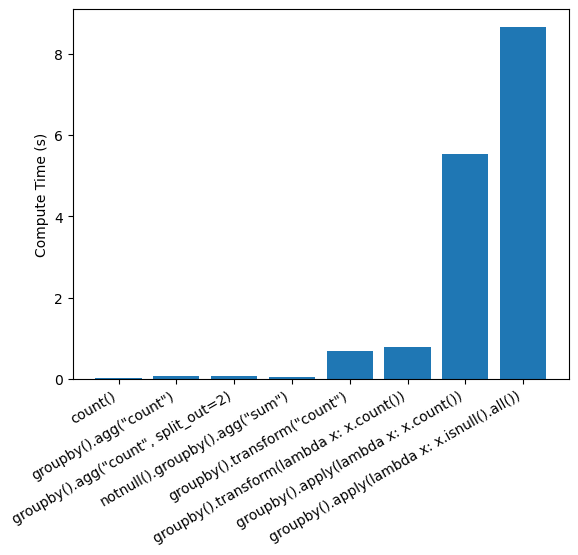

In [32]:
# show groupby_options dictionary
plt.bar(groupby_options.keys(), groupby_options.values())
plt.xticks(rotation=30, ha='right')
plt.ylabel('Compute Time (s)')

Click ... to show **solution**.


The `GroupBy.apply()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.core.groupby.groupby.groupby.apply#cudf.core.groupby.groupby.GroupBy.apply) function will apply a Python transformation function over the grouped chunk. We can achieve faster results with `GroupBy.agg()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.core.groupby.groupby.groupby.agg#cudf.core.groupby.groupby.GroupBy.agg). Upon examining the _profile_ of each task graph, we can see `GroupBy.agg()` is more efficient. More information about the `GroupBy` API can be found [here](https://docs.rapids.ai/api/cudf/stable/api_docs/groupby.html). 


We used `.compute()` to create a few `cudf.DataFrame`s in order to inspect the results, but this should be avoided when possible. We use `del` to get rid of the data in GPU memory for these objects and free up memory. What is left in the GPU memory is the original `dask_cudf.core.DataFrame` that was persisted. 

In [33]:
# clean up
del null_category_products, null_category_products_list, null_category_products_ddf, null_category_products_count_ddf
gc.collect()

457

<p><img src='images/tip.png' width=720></p>

Note that `df.groupby(df['col'])` is syntactical sugar for `df.groupby('col')`, which is designed to make things easier to read or to express. Additionally, `DataFrame.groupby()` returns a `DataFrameGroupBy` while `DataFrame.groupby()['col']` returns a `SeriesGroupBy`. Understanding the types of object and their shape returned by each method will help us program effectively with DataFrames, especially with `.apply()`. 

<a name='s1-4.2'></a>
### Data Imputation ###
The `.fillna()` method is used to fill missing values. There are several considerations when attempting to infer missing values: 
* A common technique is to replace missing data with statistical estimates such as mean, median, or mode. Alternatively, we can perform interpolation or extrapolation to fill the missing data. Linear interpolation is the simplest method but other options can also be useful. We can impute with `mean` by: 
    
    ```
    df['value'].fillna(df[['group', 'value']].groupby('group')['value'].transform('mean'))
    ```
    
    or 
    
    ```
    df[['group', 'value']].groupby('group')['value'].transform(lambda x: x.fillna(x.mean()))
    ```

* For time-series data or when sequencing matters, last observation carried forward is a common method for imputation. This method replaces missing values with the last observed value. A similar technique is next observation carried backward. We can use the `method` parameter: 
    * `ffill`: Ffill or forward-fill propagates the last observed non-null value forward until another non-null value is encountered
    * `bfill`: Bfill or backward-fill propagates the first observed non-null value backward until another non-null value is met
* Another imputation technique replaces all occurrences of missing value within a variable explicitly with an arbitrary value. 
    * We can set an chosen value to replace all missings. Such a substitution could be -999, for example, to clearly indicate that the value is missing
    
When data is missing, we can optionally create an additional binary variable to indicate whether data was missing for that observation. This may help capture the significance of missing values. 

<a name='s1-e4'></a>
### Exercise #4 - Check Missing Values ###
We will try a similar process with `brand`. 

**Instructions**: <br>
* Modify the `<FIXME>` only and execute the below cell to see if we can impute missing `brand` values. 

In [34]:
# check if brand can be inferred
# get list of product_ids with missing brand values
null_brand_products=ddf.loc[ddf['brand'].isnull(), 'product_id'].unique()
null_brand_products_list=null_brand_products.compute()

# get records associated with missing brand values
null_brand_products_ddf=ddf.loc[ddf['product_id'].isin(null_brand_products_list), ['product_id', 'brand']]

# perform groupby aggregation
null_brand_products_count_ddf=null_brand_products_ddf.groupby('product_id')['brand'].agg('count')

print(f"There are {(null_brand_products_count_ddf>0).sum().compute()} products with at least one brand populated. ")

There are 7226 products with at least one brand populated. 


Click ... for **solution**. 

Unlike `category_code`, there are several `product_id` groups with partially missing `brand` values. Therefore we have an opportunity to infer a value to fill the null values with. For string categorical values, the _mode_ is a common option. The mode calculates the value that appears most often. Since this is not a supported aggregation, according to the [documentation](https://docs.rapids.ai/api/cudf/stable/user_guide/groupby/), we have to use `.groupby().apply()`. We will replace null values with the most frequently occurring value per `product_id` group. The `.groupby().transform()` and `.groupby().apply()` scales poorly with large amounts of groups, therefore we only want to perform this procedure on a subset of relevant records. 

There are several ways to approach this. We breakdown the procedure into the following steps:
1. Get records associated with multiple `brand` values
2. Generate lookup table with `product_id` values and their most frequent `brand` values (example below)
| product_id  | missing_brand_mode  |
| ----------- | ------------------- |
| 1002701     | huawei              |
| 1004976     | samsung             |
3. Merge original DataFrame with lookup table, fill missing `brand` values, and delete lookup table
4. Check missing `brand` values

**Step 1**. Get records associated with multiple `brand` values

In [35]:
# get list of product_id values with multiple brand values
multi_brand_products_list=null_brand_products_count_ddf[(null_brand_products_count_ddf>0)].index.compute()

# get records associated with multiple brand values
multi_brand_products_ddf=ddf.loc[ddf['product_id'].isin(multi_brand_products_list), ['product_id', 'brand']]

# preview DataFrame
multi_brand_products_ddf.head()

product_id brand
270   100113382  <NA>
310   100113382  <NA>
378   100113382  <NA>
400   100113382  <NA>
487   100113382  <NA>

**Step 2**. Generate lookup table with `product_id` values and their most frequent `brand` values

**Note**: `.groupby().apply()` requires shuffling and scales very poorly with large number of groups. 

In [36]:
# create lookup table
# impute missing values with mode
multi_brand_products_lookup=multi_brand_products_ddf.groupby('product_id').apply(lambda g: g.mode(), meta={'product_id': 'int32', 'brand': 'object'})
multi_brand_products_lookup.columns=['product_id', 'missing_brand_mode']

# preview lookup table
multi_brand_products_lookup.head()

/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 1785 groups.
  warnings.warn(


product_id missing_brand_mode
0     1002701             huawei
0     1004976            samsung
0     1701442                 hp
0     2401795             elikor
0     2501023   hotpoint-ariston

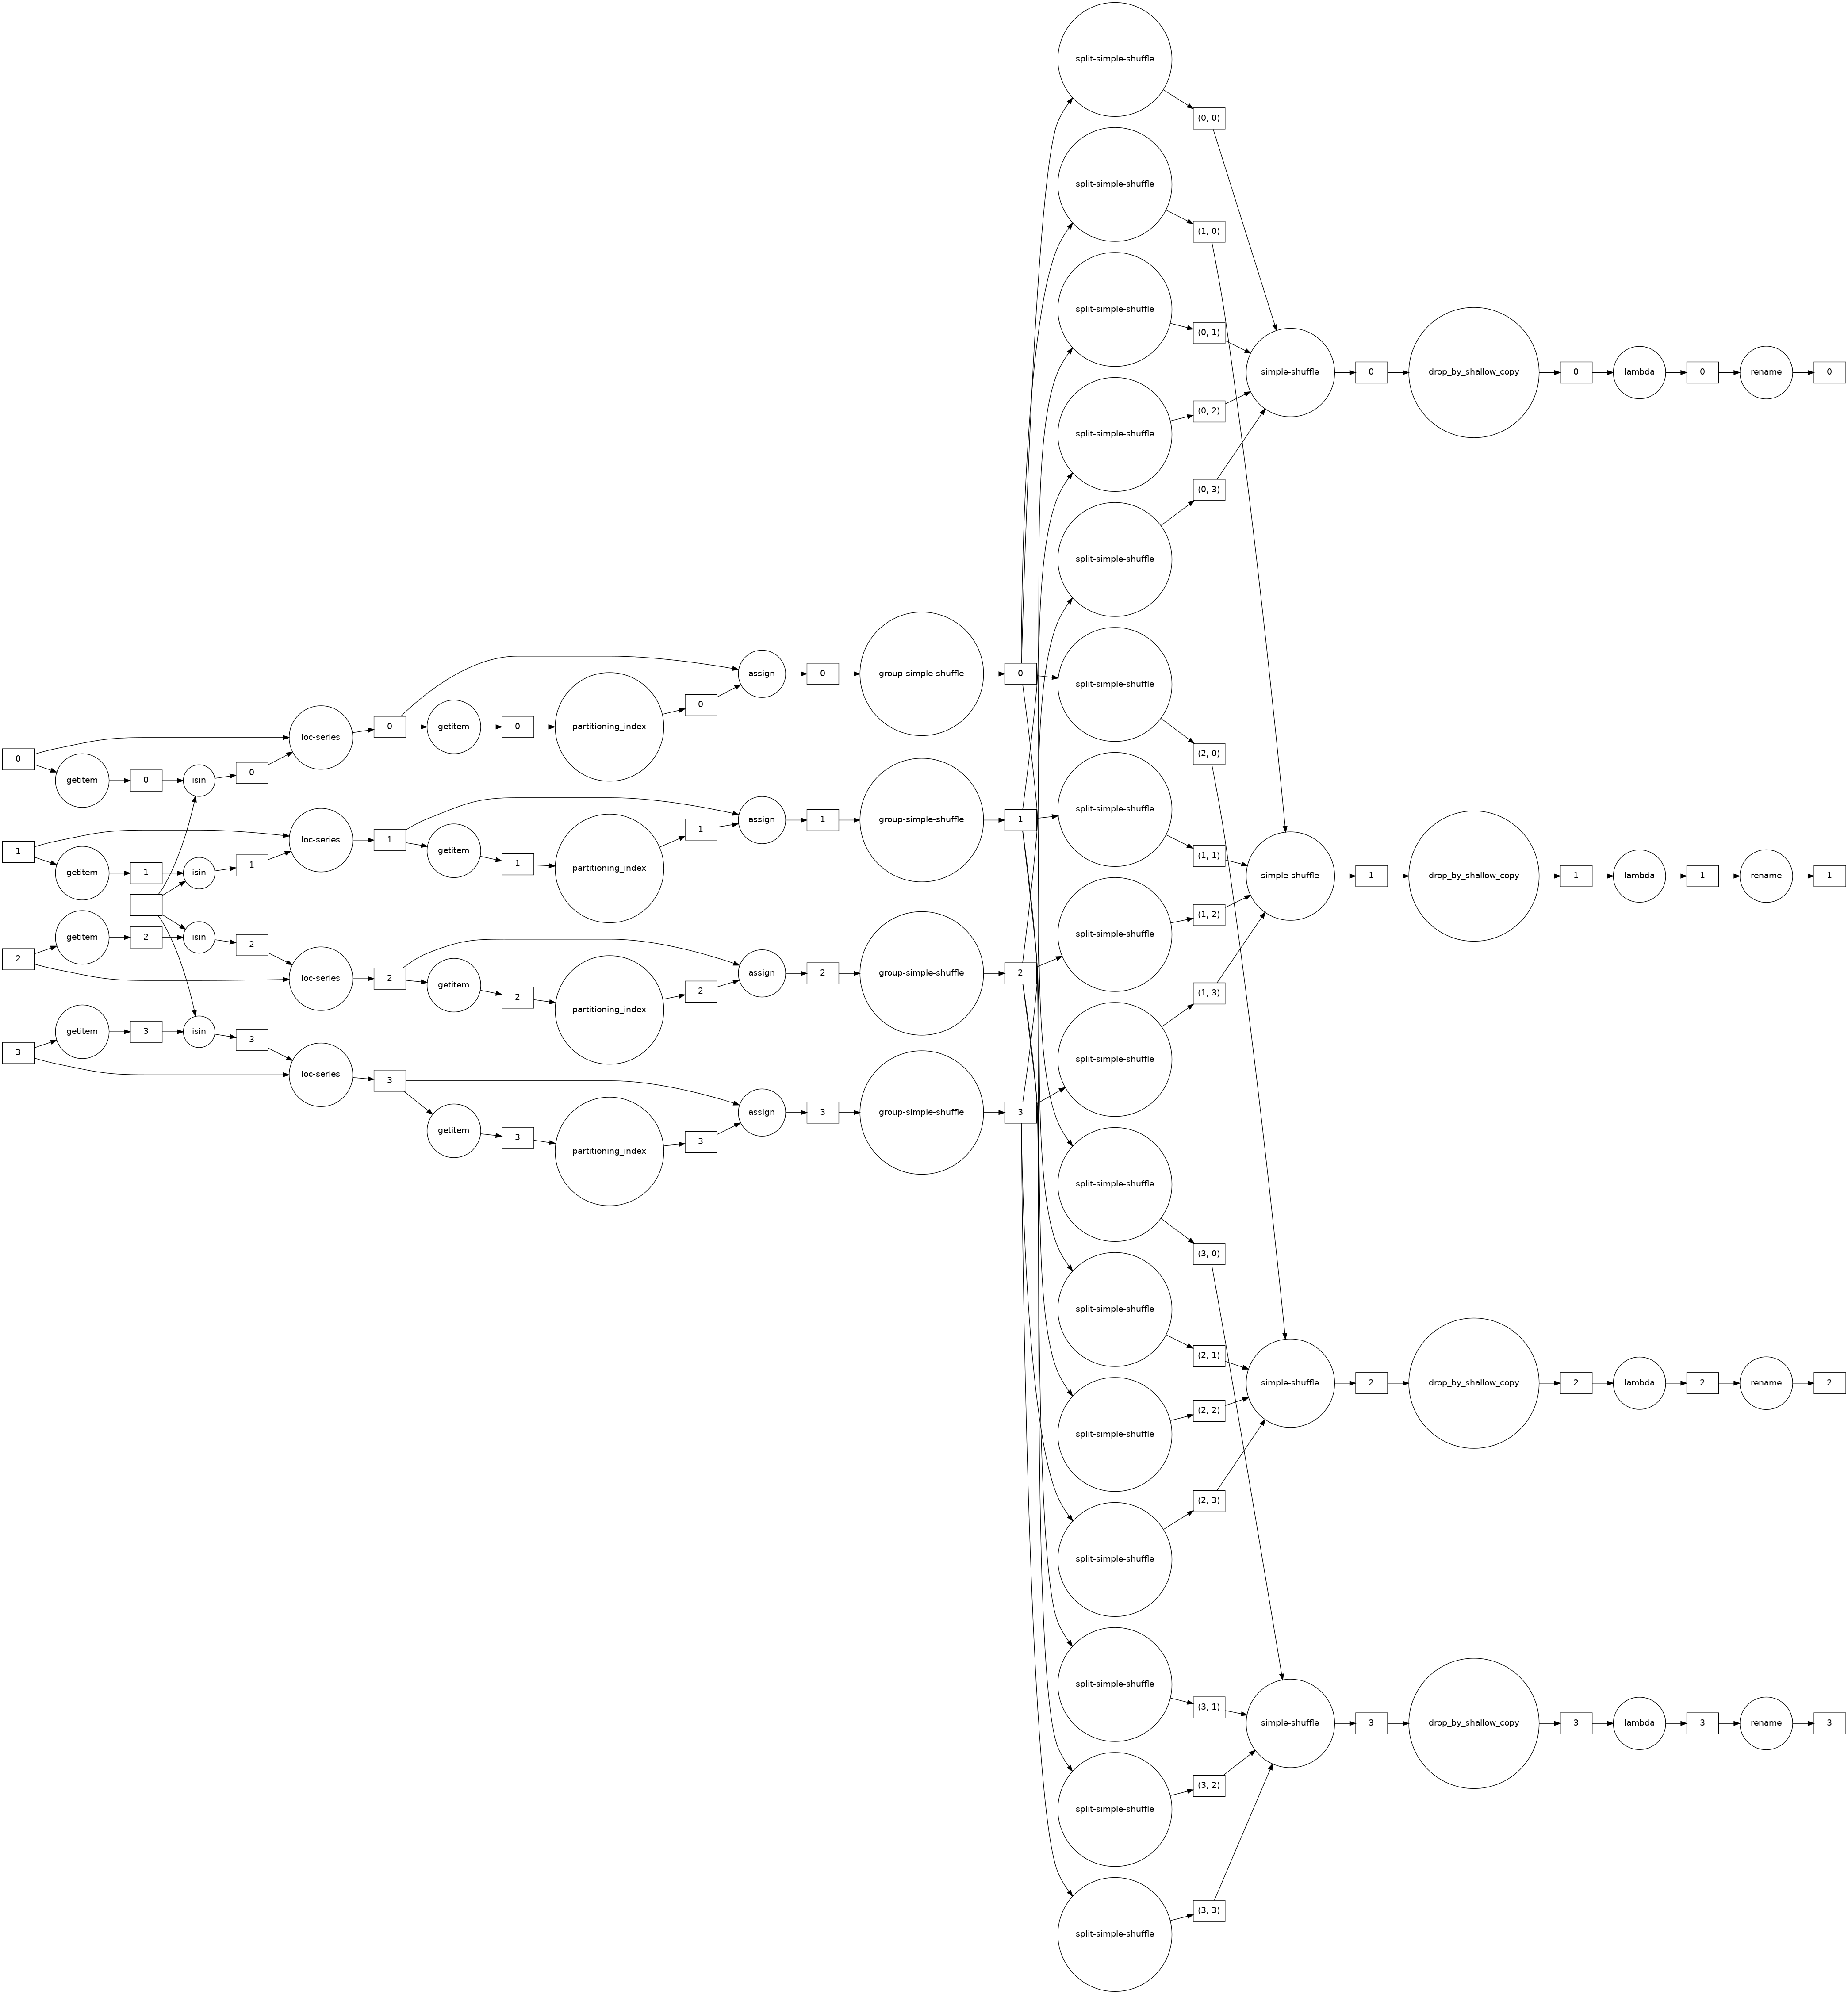

In [37]:
multi_brand_products_lookup.visualize(rankdir='LR')

**Step 3**. Merge original DataFrame with lookup table and fill missing `brand` values

Merging data requires special consideration. We will try this using various approaches and discuss the difference: 
1. Join a Dask DataFrame with a cuDF DataFrame
2. Join a Dask DataFrame with another Dask DataFrame with multiple partitions
3. Join a Dask DataFrame with another Dask DataFrame on a single partition

In [38]:
# since we want to compare multiple approaches, we persist the data into distributed memory, where new tasks will start from
multi_brand_products_lookup=multi_brand_products_lookup.persist()
wait(multi_brand_products_lookup)

# load small DataFrame in memory
multi_brand_products_lookup_in_memory=multi_brand_products_lookup.compute()

# create a dictionary to compare options
merge_options={}

/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 1785 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 1800 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 1867 groups.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/groupby/groupby.py:842: UserWarning: GroupBy.apply() performance scales poorly with number of groups. Got 1774 groups.
  warnings.warn(


In [39]:
# ddf=ddf.merge(another_multi_brand_products_lookup, how='left', on='product_id').persist()#.compute()
time=timeit(
    lambda: wait(ddf.merge(multi_brand_products_lookup_in_memory, how='left', on='product_id').persist()), 
    number=1
)
merge_options['merge_cudf_dataframe']=time
print(f'Took {time} seconds')

Took 0.44226061400058825 seconds


In [ ]:
# ddf=ddf.merge(multi_brand_products_lookup, how='left', on='product_id').persist()#.compute()
time=timeit(
    lambda: wait(ddf.merge(multi_brand_products_lookup, how='left', on='product_id').persist()), 
    number=1
)
merge_options['merge_dask_dataframe_multi_partitions']=time
print(f'Took {time} seconds')

In [ ]:
multi_brand_products_lookup=multi_brand_products_lookup.repartition(npartitions=1).persist()
wait(multi_brand_products_lookup)

# ddf=ddf.merge(multi_brand_products_lookup, how='left', on='product_id').persist()#.compute()
time=timeit(
    lambda: wait(ddf.merge(multi_brand_products_lookup, how='left', on='product_id').persist()), 
    number=1
)
merge_options['merge_dask_dataframe']=time
print(f'Took {time} seconds')

In [ ]:
# show groupby_options dictionary
plt.bar(merge_options.keys(), merge_options.values())
plt.xticks(rotation=30, ha='right')
plt.ylabel('Compute Time (s)')

<p><img src='images/tip.png' width=720></p>

Joining a Dask DataFrame with a small cuDF DataFrame is fast as it can be done in parallel. Each partition in the Dask DataFrame can be joined against the single cuDF DataFrame without incurring overhead. When joining a left Dask DataFrame with a right Dask DataFrame, we can turn the right DataFrame into a single partition to get fast results if we can't or don't want to load the right DataFrame into memory using `.repartition()`. These two operations are programmatically equivalent which means there's no meaningful difference in performance between them. However, merging two Dask DataFrames is an expensive operation in a distributed computing context. If Dask doesn't know how the data is partitioned, it needs to move all of the data around by performing a shuffle so that rows with matching values in the joining column(s) end up in the same partition. This is an extremely memory-intensive process and often cause the workers to run out of memory or spill. This is a situation we want to avoid. 

In [ ]:
# merge with lookup table
ddf=ddf.merge(multi_brand_products_lookup_in_memory, how='left', on='product_id')

# fill missing value with mode
ddf['brand']=ddf['brand'].fillna(ddf['missing_brand_mode'])

# drop reference data
ddf=ddf.drop(columns='missing_brand_mode')

# persist data into distributed memory
ddf=ddf.persist()
wait(ddf)

**Step 4**. Check missing `brand` values

In [ ]:
# check if brand can be inferred
# get list of product_ids with missing brand values
null_brand_products=ddf.loc[ddf['brand'].isnull(), 'product_id'].unique()
null_brand_products_list=null_brand_products.compute()

# check if imputation was effective
# get records associated with missing brand values
null_brand_products_ddf=ddf.loc[ddf['product_id'].isin(null_brand_products_list), ['product_id', 'brand']]

# perform groupby aggregation
null_brand_products_count_ddf=null_brand_products_ddf.groupby('product_id')['brand'].agg('count')

print(f"There are {(null_brand_products_count_ddf>0).sum().compute()} products with at least one brand populated. ")

In [ ]:
# clean up
del multi_brand_products_list, multi_brand_products_ddf, multi_brand_products_lookup, multi_brand_products_lookup_in_memory
del null_brand_products, null_brand_products_list, null_brand_products_ddf, null_brand_products_count_ddf
gc.collect()

<p><img src='images/tip.png' width=720></p>
We could have done the same procedure on the entire dataset, but filtering down to only affected records first will significantly reduce the compute and memory needed. 

<a name='s1-e5'></a>
### Exercise #5 - Static Fill Null Values ###
We can use the `.fillna()`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/api/cudf.dataframe.fillna/) method to fill null values. 

**Instructions**: <br>
* Modify the `<FIXME>` only and execute the below cell to fill null values with the string literal value `UNKONWN`. 

In [ ]:
# fill with static value
ddf[['category_code', 'brand']]=ddf[['category_code', 'brand']].fillna('UNKNOWN')

Click ... to show **solution**. 

Sometimes it may be necessary to drop records (rows or columns) with missing value. This should be the last resort. 

In [ ]:
# drop records with missing user_session value
ddf=ddf.dropna(subset=['user_session'])

In [ ]:
# check data
ddf.isna().sum().compute()

<a name='s1-5'></a>
## Filter Relevant Data ##
The dataset contains a lot of noisy `view` records, which we can exclude. Furthermore, we will apply additional data cleaning procedures such as: 
* Filter out `purchase` records that were not `cart`
* Filter out `cart` records that were also `purchase`

In [ ]:
# filter out view records
ddf=ddf[ddf['event_type']!='view']

# create unique identifier for session_product
ddf['session_product']=ddf['user_session']+'_'+ddf['product_id'].astype(str)

# get DataFrame for purchase records
ddf_purchase=ddf[ddf['event_type']=='purchase']
purchase_session_product=ddf_purchase['session_product'].compute()

# get DataFrame for cart records
ddf_cart=ddf[ddf['event_type']=='cart']
cart_session_product=ddf_cart['session_product'].compute()

# filter out purchase records that were not cart 
ddf_purchase=ddf_purchase[ddf_purchase['session_product'].isin(cart_session_product)]

# filter out cart records that were purchase
ddf_cart=ddf_cart[~ddf_cart['session_product'].isin(purchase_session_product)]

# set target
ddf_cart['target']=0
ddf_purchase['target']=1

# concatenate DataFrames
ddf=dask_cudf.concat([ddf_purchase, ddf_cart])

# shuffle on event_time to make even
ddf=ddf.shuffle('event_time', npartitions=4)
ddf=ddf.persist()

In [ ]:
# clean up
del purchase_session_product
del cart_session_product
del ddf_cart
del ddf_purchase
gc.collect()

cuDF supports powerful `string`[[doc]](https://docs.rapids.ai/api/cudf/stable/api_docs/string_handling.html#) and `datetime` methods to handle common use cases. 

In [ ]:
# split category_code into separate columns
ddf[['cat_0', 'cat_1', 'cat_2', 'cat_3']]=ddf['category_code'].str.split('.', n=3, expand=True).fillna('NA')

# extract data time values
ddf['date']=ddf['event_time'].dt.floor('D')
ddf['ts_hour']=ddf['event_time'].dt.hour
ddf['ts_minute']=ddf['event_time'].dt.minute
ddf['ts_weekday']=ddf['event_time'].dt.weekday
ddf['ts_day']=ddf['event_time'].dt.day
ddf['ts_month']=ddf['event_time'].dt.month
ddf['ts_year']=ddf['event_time'].dt.year

<a name='s1-6'></a>
## Save to Parquet Format ##
After processing the data, we persist it for later use. [Apache Parquet](https://parquet.apache.org/) is a columnar binary format and has become the de-facto standard for the storage of large volumes of tabular data. Converting to Parquet file format is important and CSV files should generally be avoided in data products. In fact, many developers will start their analysis by first converting CSV files to the Parquet file format. There are many reasons to be Parquet format for analytics: 
* The columnar nature of Parquet files allows for column pruning, which often yields big query performance gains. 
* It uses metadata to store the schema and supports more advanced data types such as categorical, datetimes, and more. This means that importing data would not require schema inference or manual schema specification. 
* It captures metadata related to row-group level statistics for each column. This enables predicate pushdown filtering, which is a form of query pushdown that allows computations to happen at the “database layer” instead of the “execution engine layer”. In this case, the database layer is Parquet files in a filesystem, and the execution engine is Dask. 
* It supports flexible compression options, making it more compact to store and more portable than a database. 

We will use `.to_parquet(path)`[[doc]](https://docs.dask.org/en/stable/generated/dask.dataframe.to_parquet.html#dask-dataframe-to-parquet) to write to Parquet files. By default, files will be created in the specified output directory using the convention `part.0.parquet`, `part.1.parquet`, `part.2.parquet`, ... and so on for each partition in the DataFrame. This can be changed using the `name_function` parameter. Ouputting multiple files lets Dask write to multiple files in parallel, which is faster than writing to a single file. 

<p><img src='images/parquet.png' width=240></p>

<p><img src='images/tip.png' width=720></p>

When working with large datasets, decoding and encoding is often an expensive task. This challenge tends to compound as the data size grows. A common pattern in data science is to subset the dataset by columns, row slices, or both. Moving these filtering operations to the read phase of the workflow can: 1) reduce I/O time, and 2) reduce the amount of memory required, which is important for GPUs where memory can be a limiting factor. Parquet file format enables filtered reading through **column pruning** and **statistic-based predicate filtering** to skip portions of the data that are irrelevant to the problem. Below are some tips for writing Parquet files: 
* When writing data, sorting the data by the columns that expect the most filters to be applied or columns with the highest cardinality can lead to meaningful performance benefits. The metadata calculated for each row group will enable predicate pushdown filters to the fullest extent. 
* Writing Parquet format, which requires reprocessing entire data sets, can be expensive. The format works remarkably well for read-intensive applications and low latency data storage and retrieval. 
* Partitions in Dask DataFrame can write out files in parallel, so multiple Parquet files are written simultaneously. 

In [ ]:
# clean up output directory
!rm -rf clean_parquet/*

# write to parquet
ddf.to_parquet('clean_parquet', index=False, overwrite=True)

In [ ]:
# show output directory
!ls -alh clean_parquet

The original data in CSV is uncompressed and requires more disk space. We were able to require the disk space requirement greatly by using Parquet file format. 

<a name='s1-6.1'></a>
### Dask-cuDF to cuDF DataFrame Conversion ###
In general, its recommended to avoid calling `.compute()` on large DataFrames, and restrict to only using it when the post-processed result needs to be inspected. Running the `.head()` or `.compute()` method on a `dask_cudf.DataFrame` will return a `cudf.DataFrame`, which means the data needs to fit comfortably on a single GPU. Furthermore, converting a Dask-cuDF DataFrame to a cudf DataFrame will result in losing out on all the benefits of Dask. Instead of `.compute()`, users can call the `.persist()` method to persist data into distributed memory. 

For data that fits into memory, cuDF can often be faster to use than Dask DataFrame. Even for large datasets, there may be a point in the process where it is reduced to more manageable level. We can consider switching to cuDF at this point. 

In [ ]:
# convert Dask-cuDF DataFrame to cudf DataFrame
gdf=ddf.compute()

# preview DataFrame
display(gdf.head())

# clean up
del gdf

In [ ]:
# clean GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

<a name='s1-7'></a>
## Summary ##
Understanding the data and the desired result can help set up computations efficiently to optimize performance. 
* Dask enables processing large datasets by using partition and memory spill mechanisms
* Getting an optimal partition size can have an importance impact on performance
* Groupby operations that do not require shuffling and result in a reduction is efficient
* Merging DataFrame in a single partition or in memory is efficient
* When choosing data format, it can be beneficial choose one that is conducisve to analytics

**Well Done!** Let's move to the [next notebook](1_02_EDA.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>